## Data import and cleaning

In [1]:
#basic library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Install yfinance and import Data
import yfinance as yf
from yfinance import Ticker

In [3]:
# function to obtain data from yfinance
import pandas as pd
from yfinance import Ticker
from datetime import datetime

def get_stock_data(tickers, start_date, end_date, selected_variable):
    start_date = datetime.strptime(start_date, '%d %m %Y')
    print(start_date)
    end_date = datetime.strptime(end_date, '%d %m %Y')
    print(end_date)

    dict = {}
    for ticker in tickers:
        ticker_obj = Ticker(ticker)
        history = ticker_obj.history(start=start_date, end=end_date)
        dict[ticker] = pd.DataFrame(history)
        dict[ticker] = dict[ticker][selected_variable]
        
    return dict


In [4]:
# set parameters for yfinance data

tickers = ['^GSPC','^DJI','^IXIC','^NDX','AAPL', 'GOOGL', 'MSFT', 'IBM', 'NVDA','META']
start_date = '01 01 2013'
end_date = '31 12 2023'

selected_variable = 'Close'

# call function to get data
stock_dict = get_stock_data(tickers, start_date, end_date, selected_variable)

2013-01-01 00:00:00
2023-12-31 00:00:00


In [5]:
# check index type
type(stock_dict['AAPL'].index)


pandas.core.indexes.datetimes.DatetimeIndex

In [6]:
print(stock_dict['IBM'].name)

Close


### Raw Data

In [7]:
def save_series_csv(series_dict, dir_path, prefix):
    for ticker, series in series_dict.items():
        series.to_csv(f'{dir_path}/{prefix}_{ticker}.csv')
        print(f'saving {ticker}\'s {prefix} data as csv...')

In [8]:
# saving raw data csv files
dir_path = '../data/'
prefix = 'raw'
save_series_csv(stock_dict, dir_path, prefix)

saving ^GSPC's raw data as csv...
saving ^DJI's raw data as csv...
saving ^IXIC's raw data as csv...
saving ^NDX's raw data as csv...
saving AAPL's raw data as csv...
saving GOOGL's raw data as csv...
saving MSFT's raw data as csv...
saving IBM's raw data as csv...
saving NVDA's raw data as csv...
saving META's raw data as csv...


## data cleanup

### format date (index)

In [9]:
def remove_index_timezone(series_dict):
    formatted_series = {}
    for ticker, series in series_dict.items():
        series.index = series.index.tz_localize(None)
    #    series.index.freq = 'D' 
    #create new dictionary
        formatted_series[ticker] = series
    return formatted_series        

In [10]:
formatted_dict = remove_index_timezone(stock_dict)

### Missing dates

how to handle missing values?
as the stock market is closed on weekends, the values will be carried forward from the previous Friday's close price/

other options:
 
 Rolling Statistics Imputation: This method substitutes missing values with a rolling statistic (like mean, median, or mode) over a specified window period. This method can handle non-random missingness and preserve temporal dependence, but the choice of window size and statistic can significantly affect the results 1.
 
 Using pandas for rolling statistics imputation
 
window_size = 5 # adjust this value according to your needs

df_imputed = df.rolling(window_size).mean().fillna(df)

Interpolation: This method estimates missing values based on the surrounding values. Linear interpolation is suitable for linear trends, while polynomial interpolation can capture more complex trends. However, these methods can distort the data if the trend is not linear or if there's a seasonal component.

Using pandas for linear interpolation
df_imputed = df.interpolate()


In [11]:
def resample_data(dict):
    resampled_data = {}
    for ticker, series in dict.items():
        resampled_series = series.resample('D').asfreq()
        resampled_data[ticker] = resampled_series
    return resampled_data

def ffill_data(dict):
    filled_data = {}
    for ticker, series in dict.items():
        filled_series = series.ffill()
        filled_data[ticker] = filled_series
    return filled_data


In [12]:
resampled_data = resample_data(formatted_dict)

In [13]:
ffilled_data = ffill_data(resampled_data)

In [14]:
data = ffilled_data

In [15]:
data_ibm_year = ffilled_data['IBM'].iloc[-365*2: , ]

### Clean Data

In [16]:
# saving cleaned data csv files
dir_path = '../data/'
prefix = 'cleaned'
save_series_csv(ffilled_data, dir_path, prefix)

saving ^GSPC's cleaned data as csv...
saving ^DJI's cleaned data as csv...
saving ^IXIC's cleaned data as csv...
saving ^NDX's cleaned data as csv...
saving AAPL's cleaned data as csv...
saving GOOGL's cleaned data as csv...
saving MSFT's cleaned data as csv...
saving IBM's cleaned data as csv...
saving NVDA's cleaned data as csv...
saving META's cleaned data as csv...


## Initial visualization

In [17]:
from matplotlib.dates import DateFormatter

def plot_time_series(dict):
    for item, series in dict.items():
        # Load the dataset
        y = dict[item]

        # Convert the datetime index to naive datetimes
        y.index = y.index.to_pydatetime()

        # Create a new figure with a specific size
        fig, ax = plt.subplots(figsize=(10, 4)) # width=10, height=5

        ax.plot(y.index, y.values, label=item)
        ax.legend()

        # Format the date
        date_form = DateFormatter("%Y-%m-%d")
        ax.xaxis.set_major_formatter(date_form)

        plt.show()



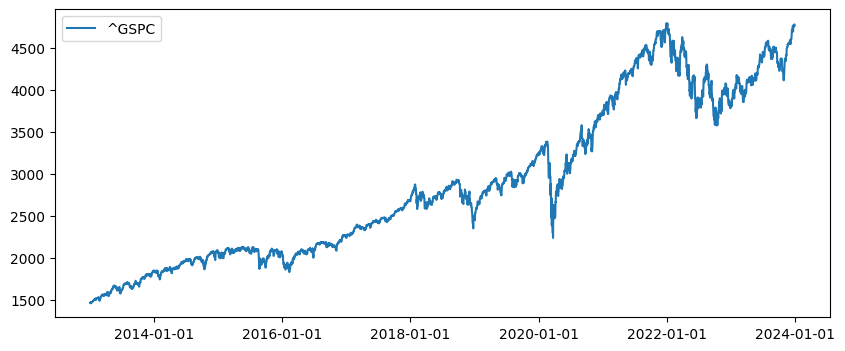

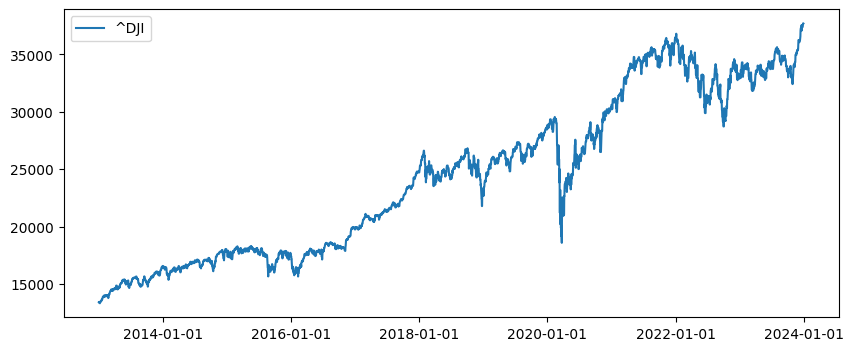

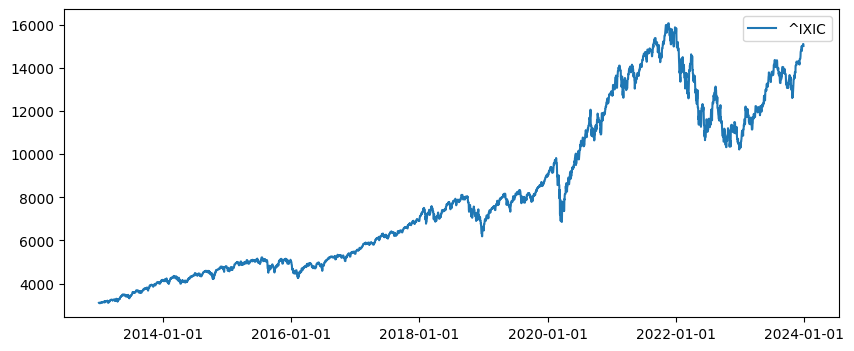

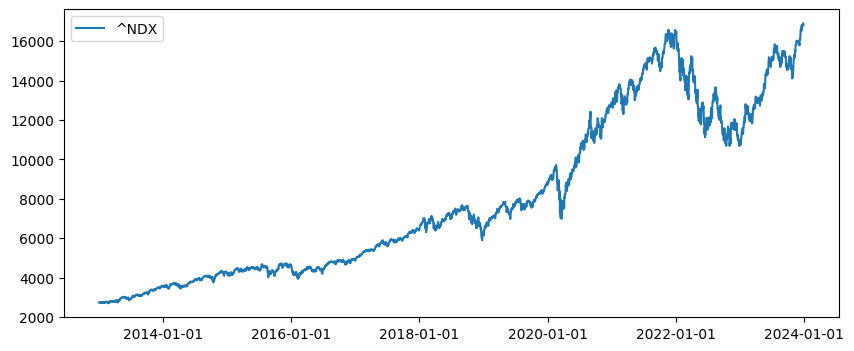

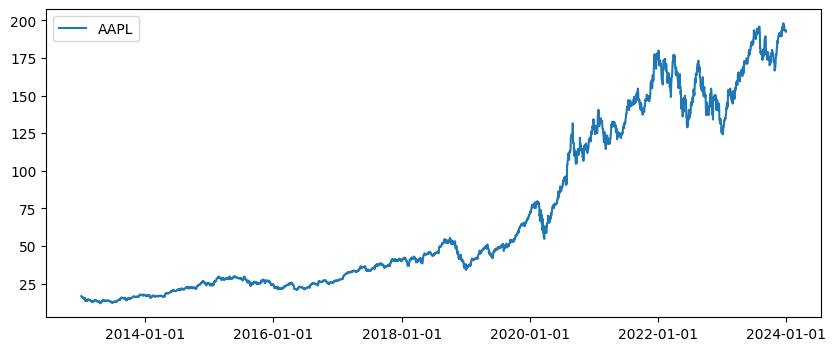

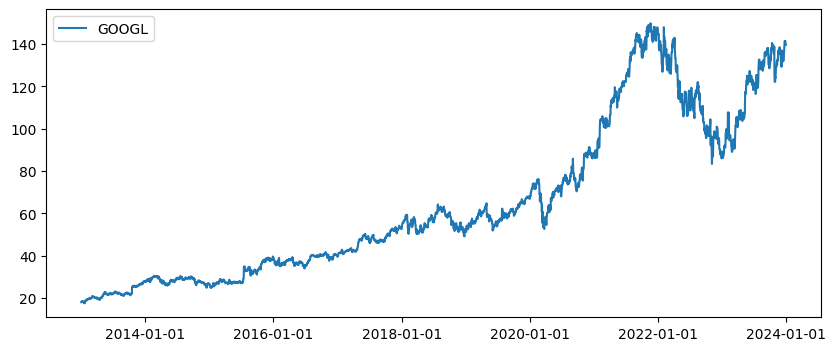

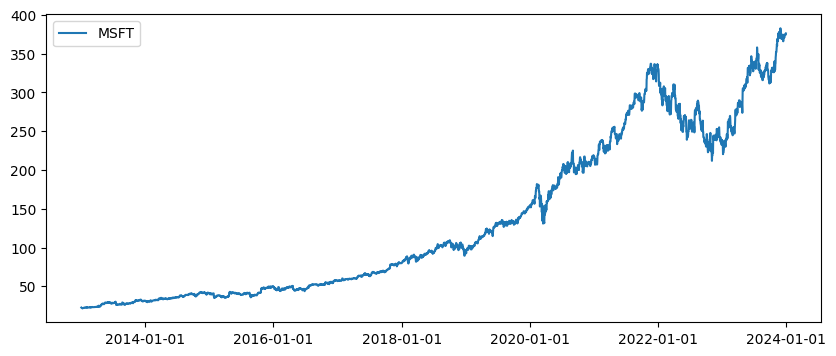

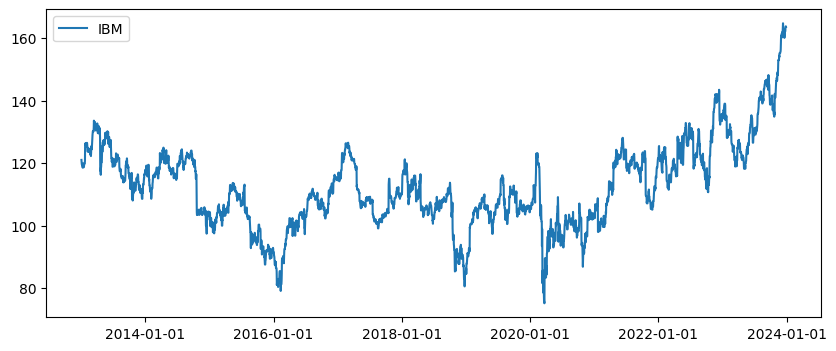

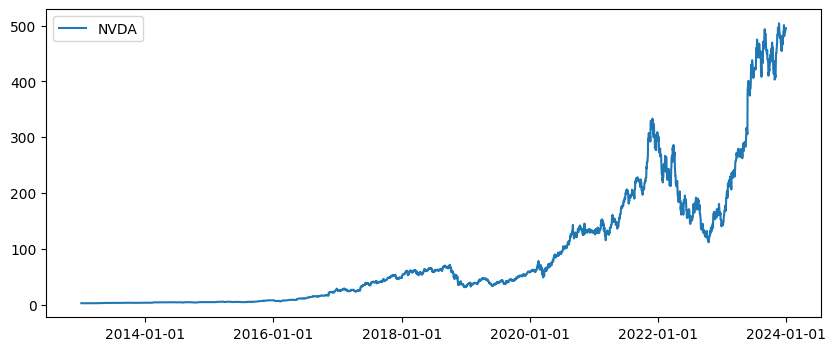

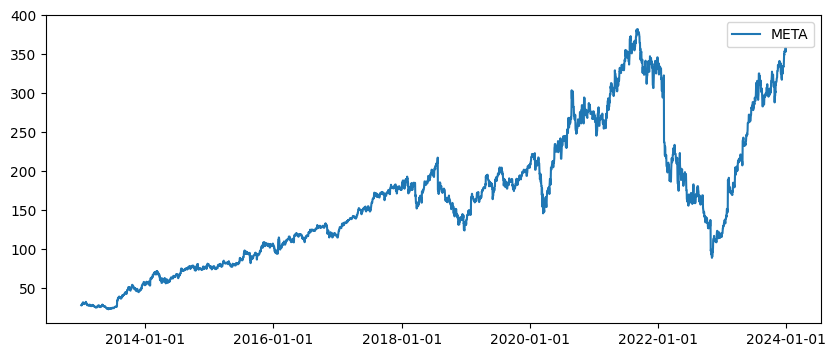

In [18]:
plot_time_series(data)

In [19]:
from sktime.utils.plotting import plot_correlations

def plot_time_series_Corr(dict):
    for item, series in dict.items():
        # Load the dataset
        y = dict[item]

        # Convert the datetime index to naive datetimes
        y.index = y.index.to_pydatetime()

        # Plot correlations
        fig, ax = plot_correlations(y, series_title=item)

        # Show the plot
        plt.show()


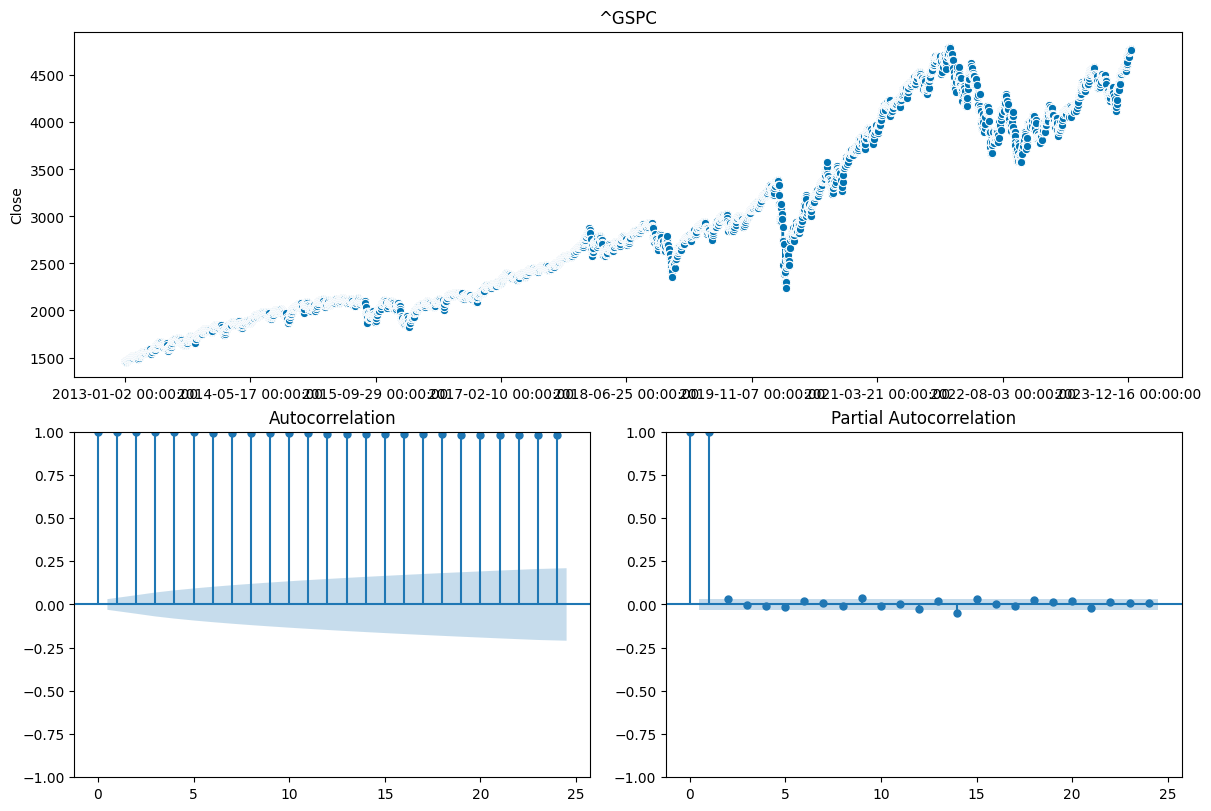

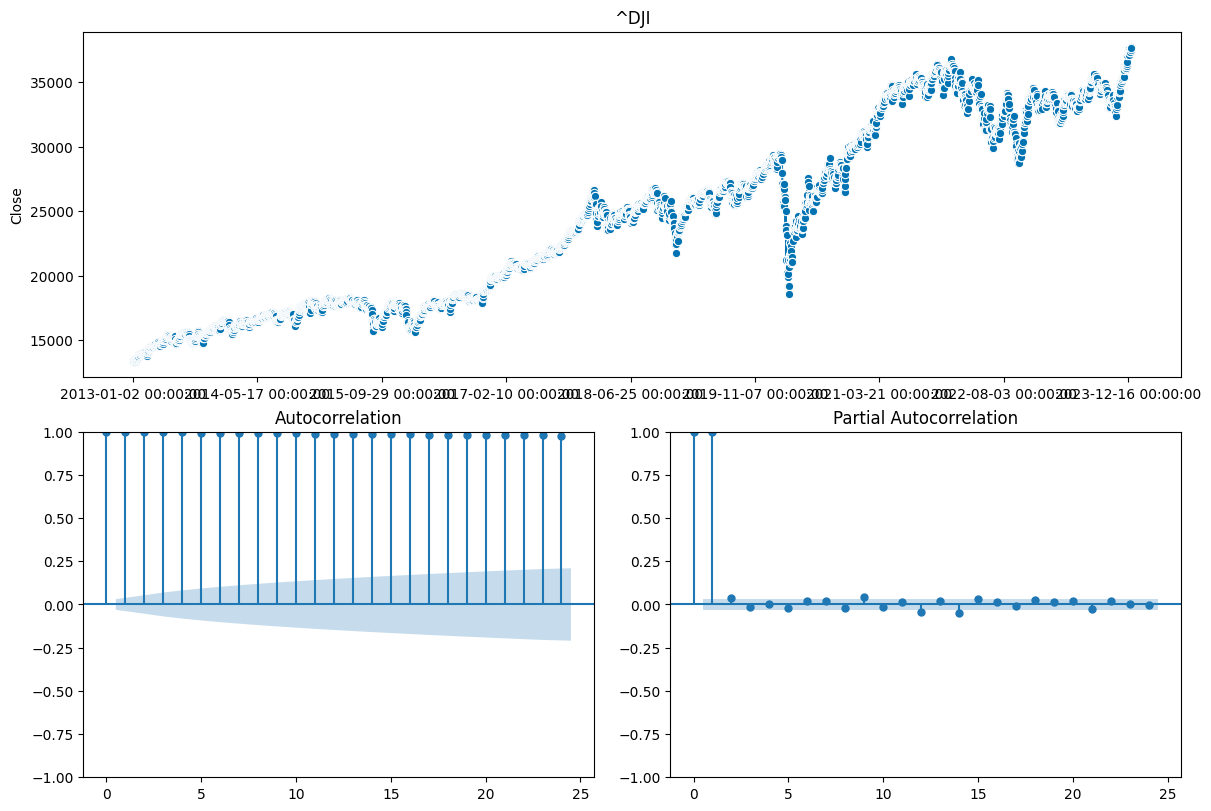

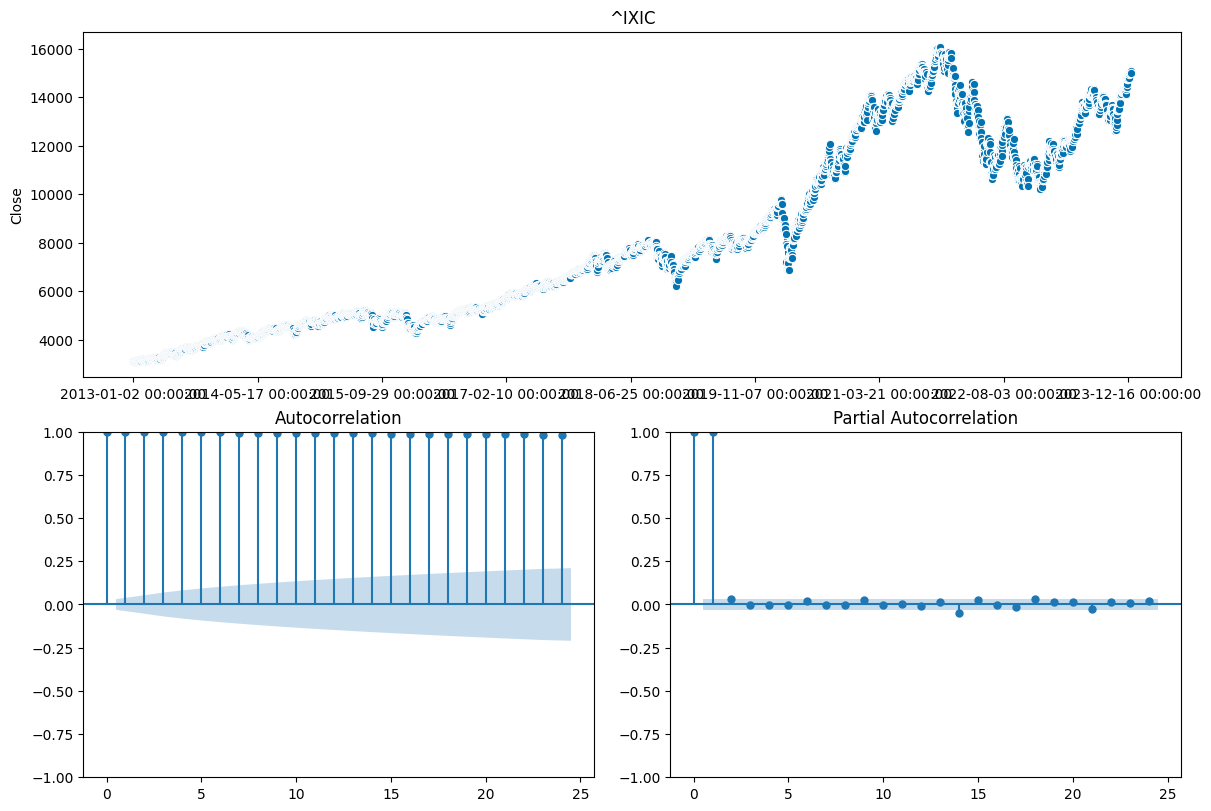

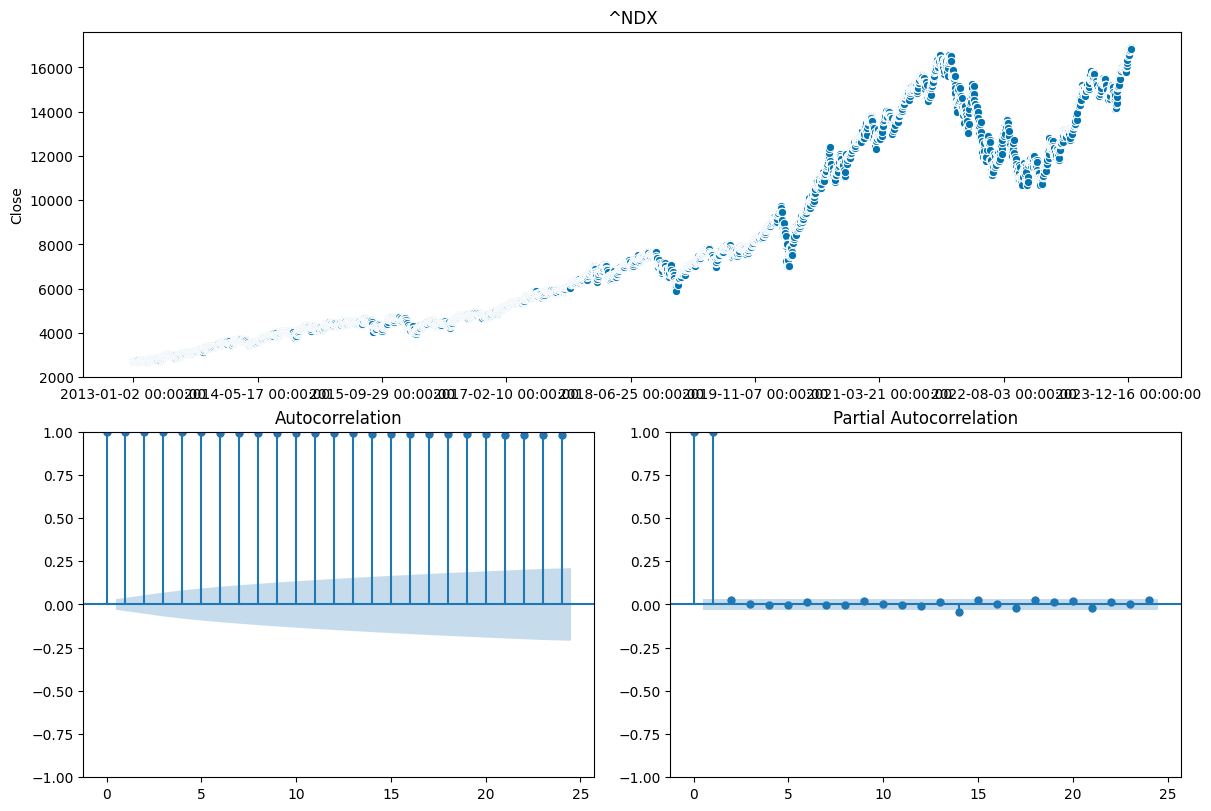

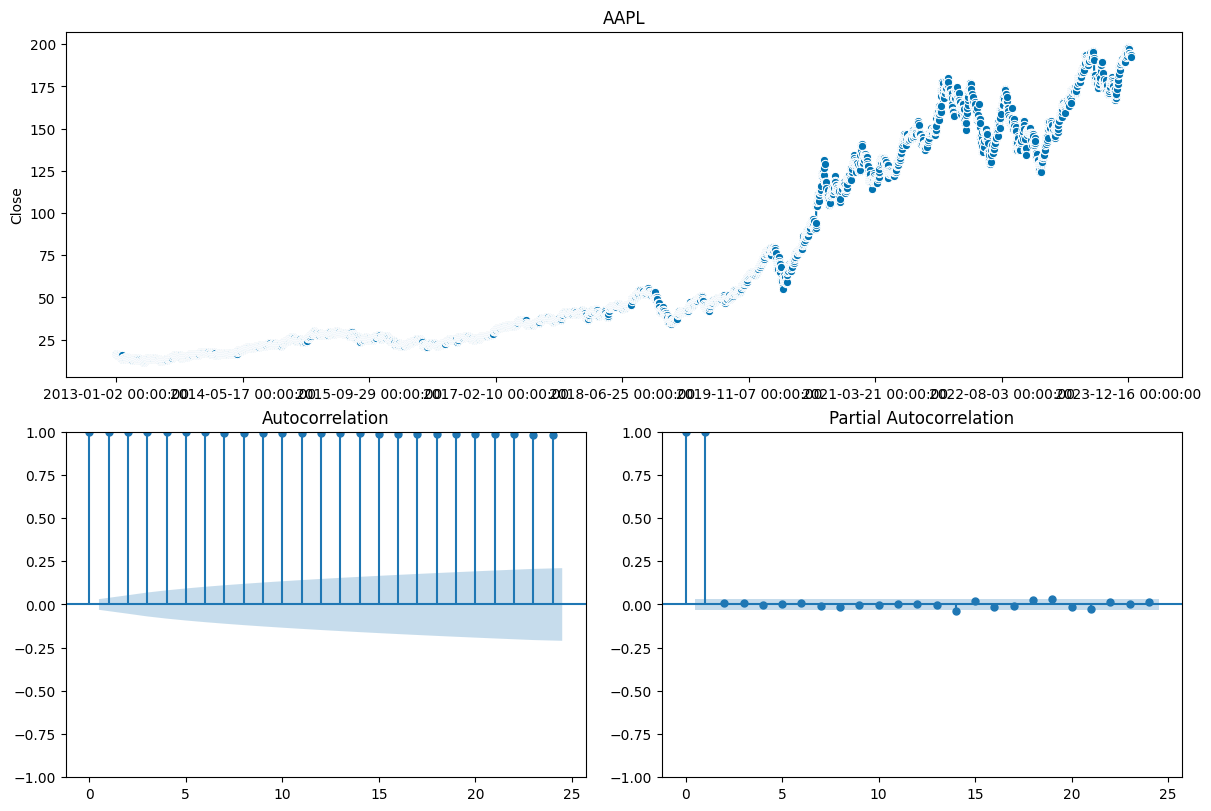

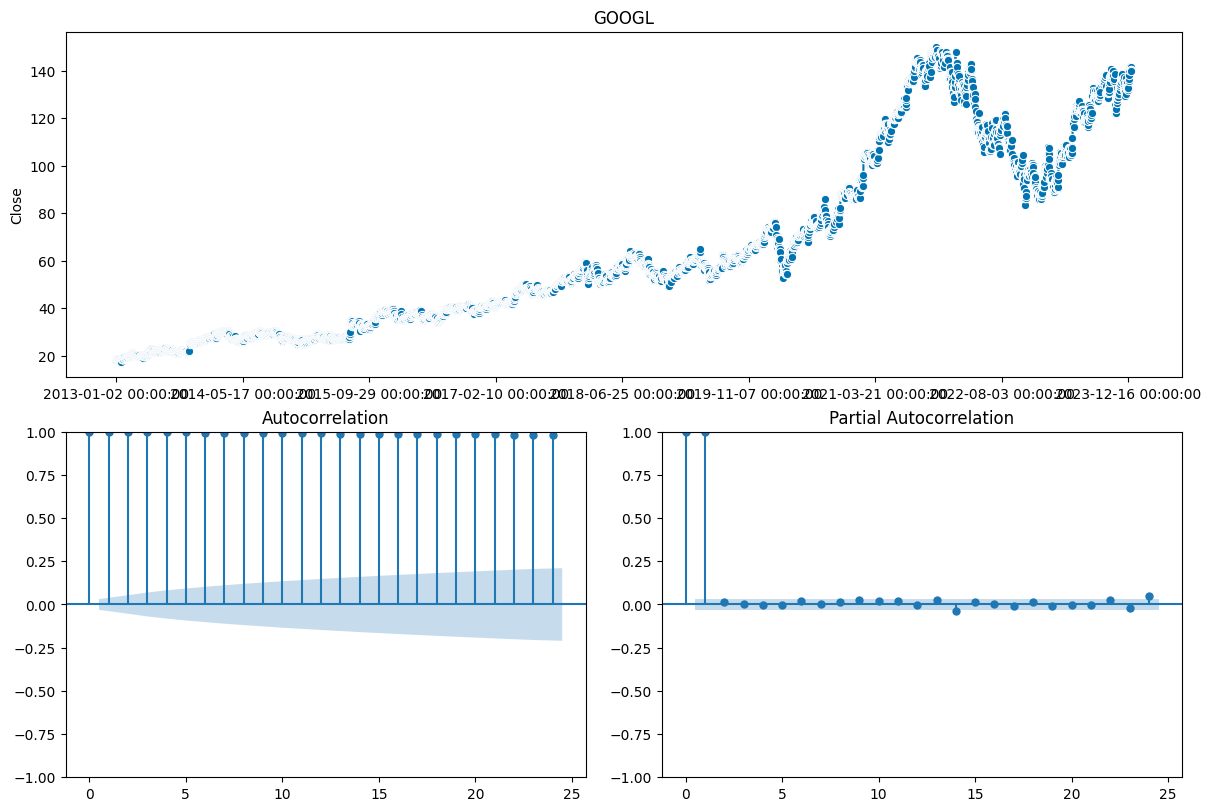

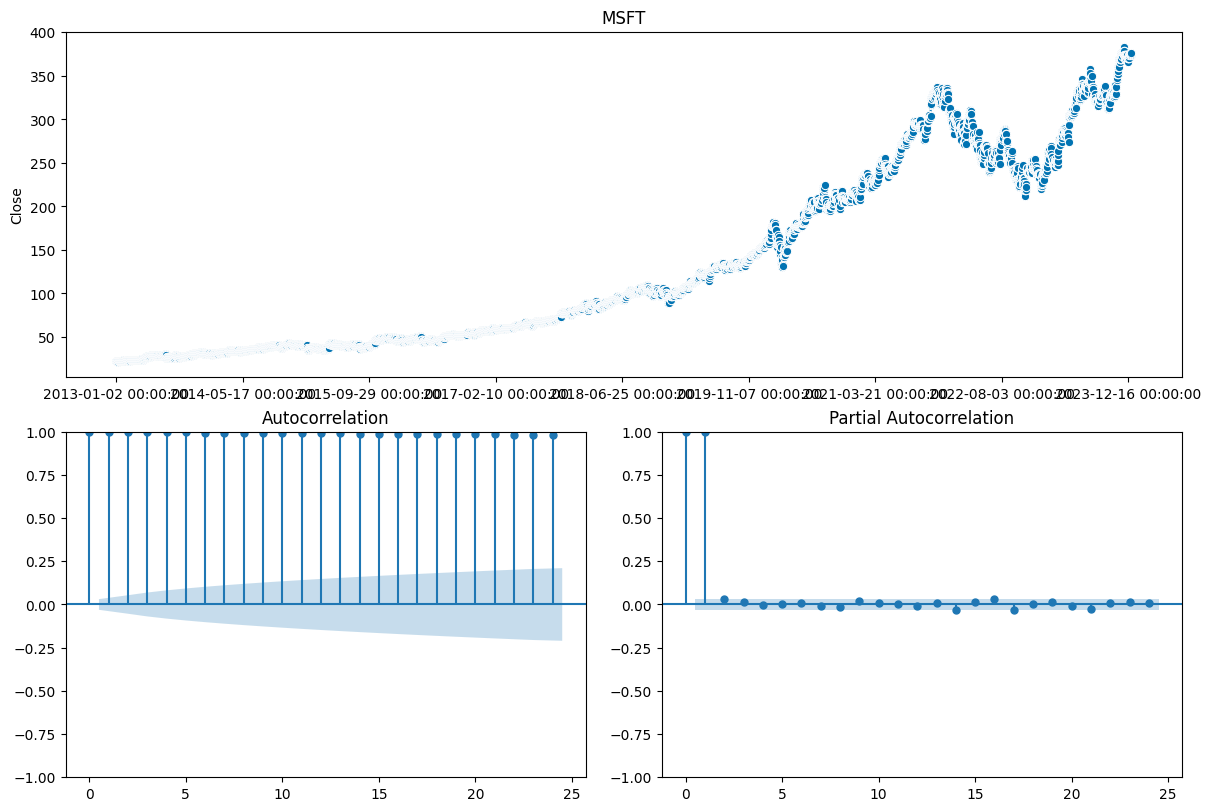

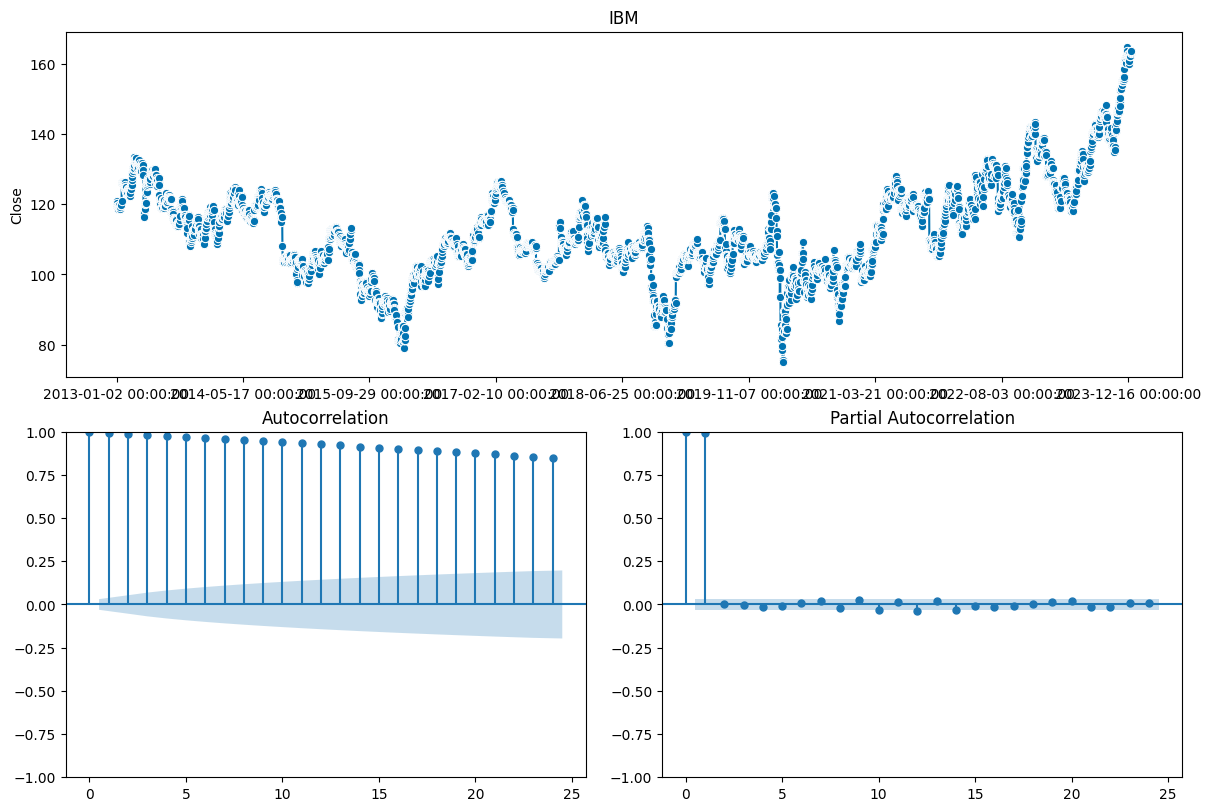

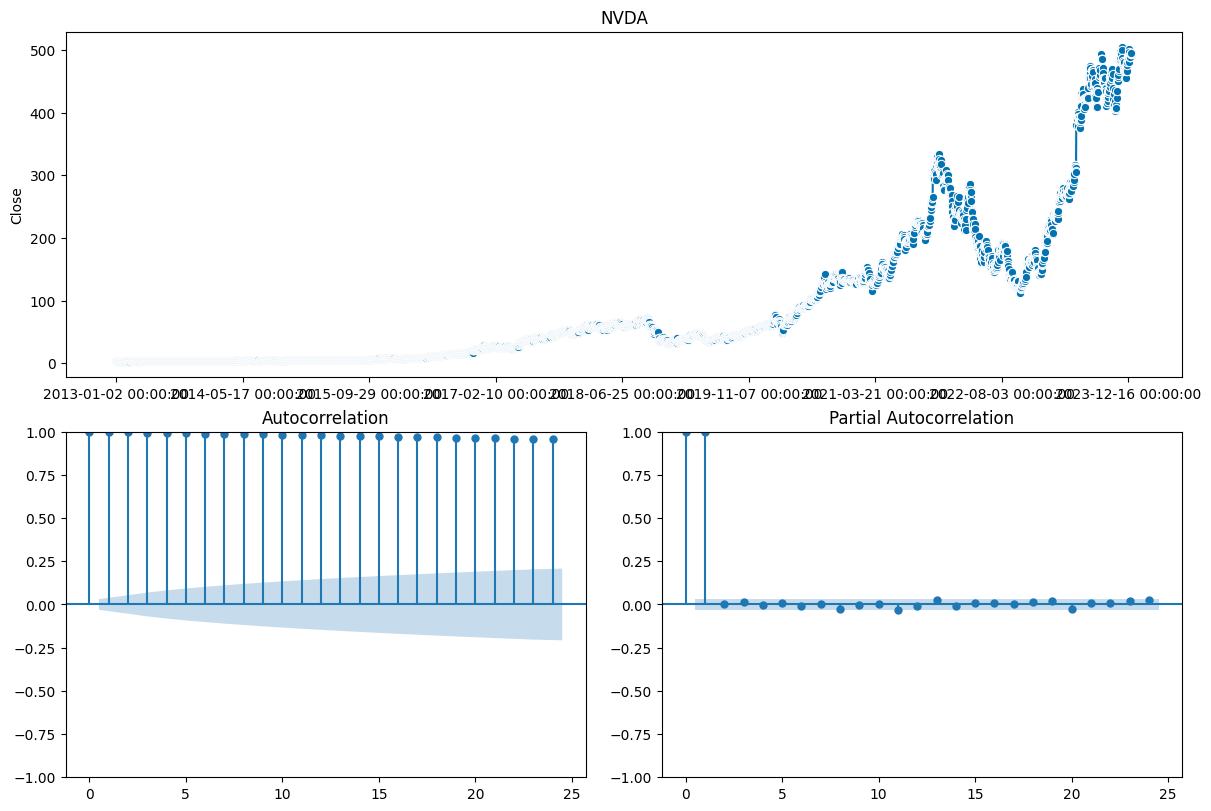

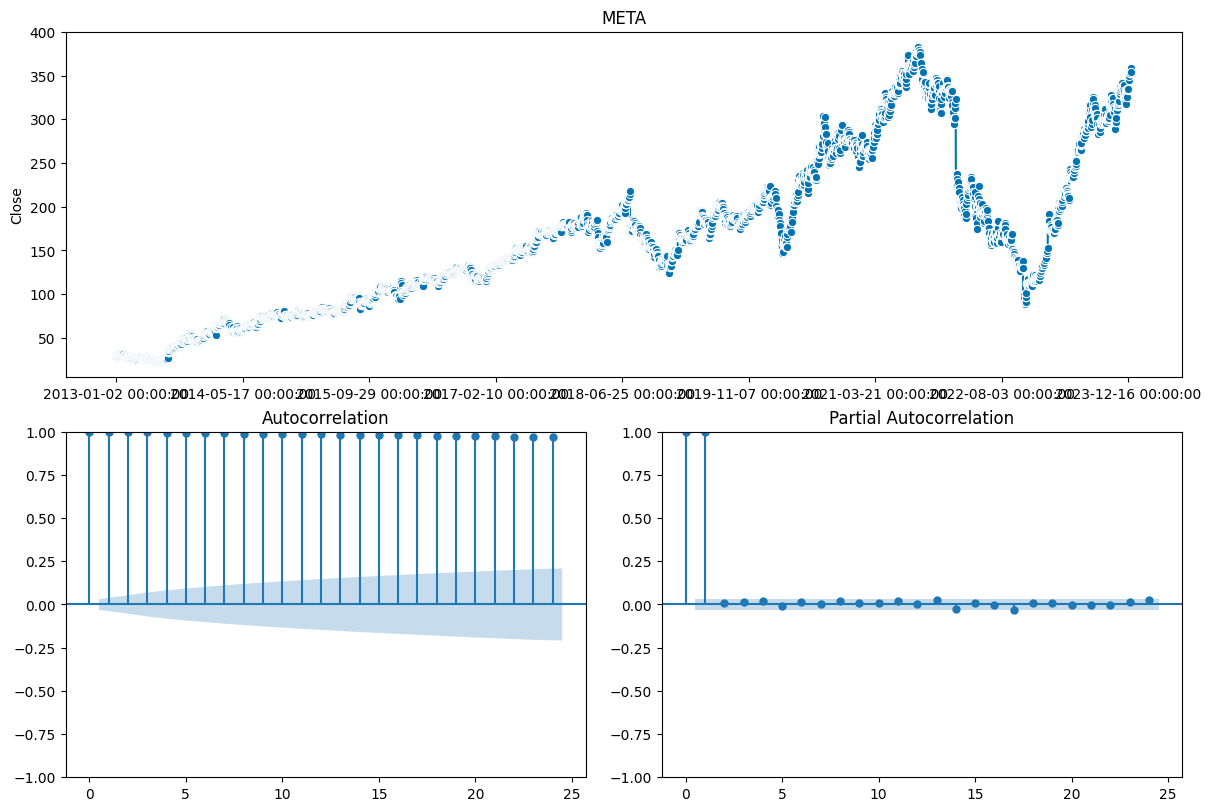

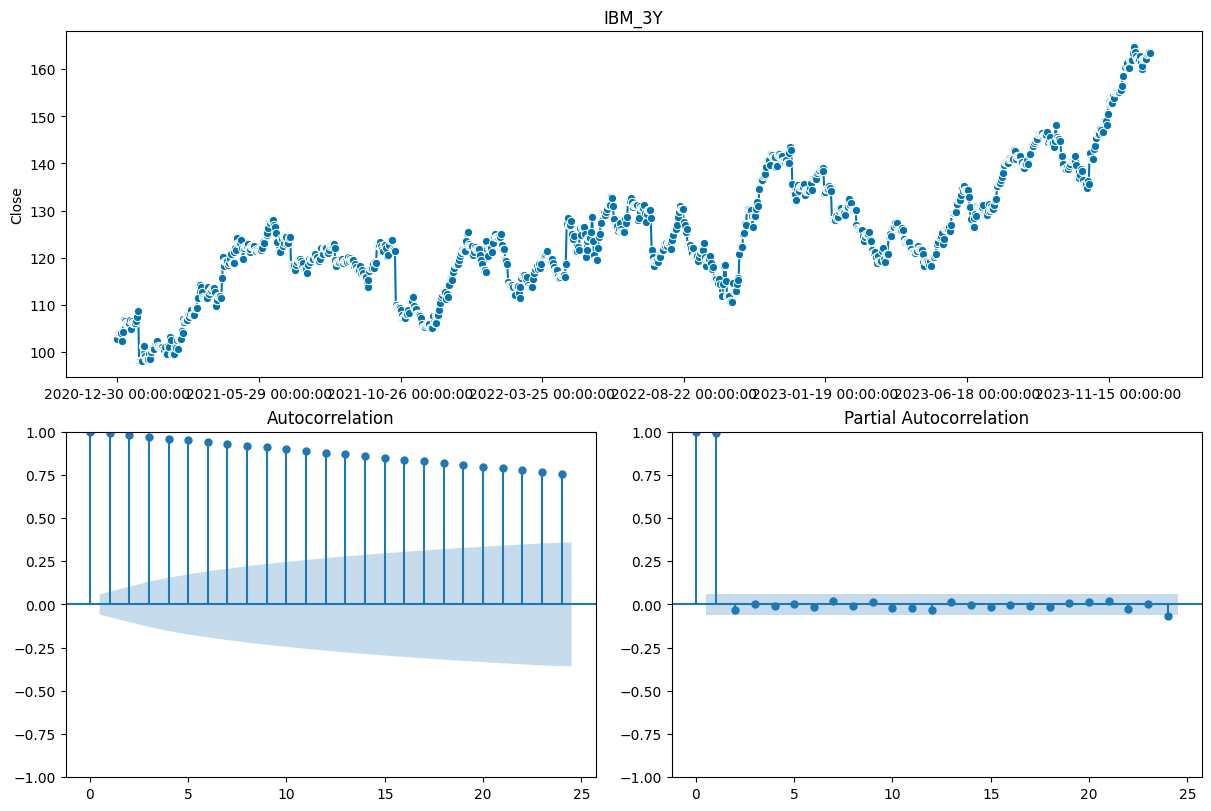

In [343]:
plot_time_series_Corr(data)

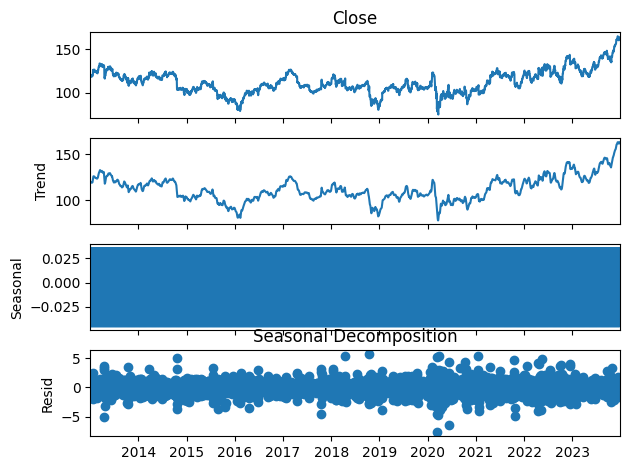

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

seasonal_decompose_result = seasonal_decompose(data['IBM'])
seasonal_decompose_result.plot()
plt.title(f'Seasonal Decomposition')
plt.show()

## time range selection

In [22]:
data['IBM_3Y'] = data['IBM'].iloc[-365*3:]
data['IBM_3Y'] = data['IBM'].iloc[-365*3:]

In [23]:
data_ibm = data['IBM_3Y']
data_ibm_all = data['IBM']

In [24]:
# set time frequency
print(data_ibm.index.freq)
data_ibm.index.freq = 'D' # Set the frequency to daily
print(data_ibm.index.freq)

None
<Day>


## Hypothesis testing: stationary data

We will observe and test the data to discover if it's stationary or not by:  
a) visual tests  
b) summary statistics by partition  
c) statistical tests  
    -- Dickey-Fuller (DF) test   
    -- Kwiatkowski-Phillips-Schmidt-Shin (KPSS)  

### Dickey-Fuller Test

Dickey-Fuller Test
The Dickey-Fuller (DF) test was developed and popularized by Dickey and Fuller (1979). The null hypothesis of DF test is that there is a unit root in an AR model, which implies that the data series is not stationary. The alternative hypothesis is generally stationarity or trend stationarity but can be different depending on the version of the test is being used.

Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

parameters:  
“c” : constant only (default).
“ct” : constant and trend.
“ctt” : constant, and linear and quadratic trend.
“n” : no constant, no trend.


In [25]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def adf_test(dict):
    results = []
    for ticker, series in dict.items():
        adfuller_test = adfuller(
            series,
            maxlag=None, 
            regression='c', 
            autolag='AIC', 
            store=False, 
            regresults=False)

        result = {
            'ticker': ticker,
            'ADF Statistic': adfuller_test[0],
            'p-value': adfuller_test[1],
            'used_lag': adfuller_test[2],
            'nobs': adfuller_test[3]
        }

        for key, value in adfuller_test[4].items():
            result[f'Critical Value {key}'] = value

        results.append(result)

    return pd.DataFrame(results)


In [26]:
adf_panel_results = adf_test(data)

In [27]:
adf_panel_results

ticker  ADF Statistic   p-value  used_lag  nobs  Critical Value 1%  \
0    ^GSPC      -0.345935  0.918742        20  3993          -3.431989   
1     ^DJI      -0.624802  0.865279        23  3990          -3.431990   
2    ^IXIC      -0.323742  0.922074        20  3993          -3.431989   
3     ^NDX       0.198602  0.972183        20  3993          -3.431989   
4     AAPL       0.503555  0.984981        26  3987          -3.431991   
5    GOOGL       0.157475  0.969773        31  3982          -3.431993   
6     MSFT       1.247724  0.996300        27  3986          -3.431992   
7      IBM      -2.079514  0.252832        13  4000          -3.431986   
8     NVDA       2.136038  0.998826        31  3982          -3.431993   
9     META      -0.703375  0.845873        16  3997          -3.431987   
10  IBM_3Y      -0.959991  0.767576         1  1093          -3.436347   

    Critical Value 5%  Critical Value 10%  
0           -2.862264           -2.567155  
1           -2.862265           -2.567156  
2           -2.862264           -2.567155  
3           -2.862264           -2.567155  
4           -2.862265           -2.567156  
5           -2.862266           -2.567157  
6           -2.862265           -2.567156  
7           -2.862263           -2.567155  
8           -2.862266           -2.567157  
9           -2.862263           -2.567155  
10          -2.864188           -2.568180

Null - hypothesis:  
No reason found to reject the null hypothesis found as the p-value is greater than the significance level  
therefore this test assumes the data is non-stationary

### KPSS test

The KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin (KPSS), is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend. In other words, the test is somewhat similar in spirit to the ADF test. A common misconception, however, is that it can be used interchangeably with the ADF test. This can lead to misinterpretations about stationarity, which can easily go undetected, causing more problems down the line.  
source: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=That%20is%2C%20if%20the%20p%2Dvalue%20is%20%3C%20significance%20level,the%20tested%20series%20is%20stationary.

In [28]:
from statsmodels.tsa.stattools import kpss
import pandas as pd

def kpss_test(dict):
    results = []
    for ticker, series in dict.items():
        kpss_test = kpss(
            series,
            regression='c', 
            nlags='auto', 
            store=False)

        result = {
            'ticker': ticker,
            'KPSS Statistic': kpss_test[0],
            'p-value': kpss_test[1],
            'used_lag': kpss_test[2]
        }

        results.append(result)

    return pd.DataFrame(results)


In [29]:
kpss_panel_results = kpss_test(data)
kpss_panel_results

/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_58882/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_58882/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_58882/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_58882/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. Th

ticker  KPSS Statistic  p-value  used_lag
0    ^GSPC        9.489351     0.01        39
1     ^DJI        9.717518     0.01        39
2    ^IXIC        9.213111     0.01        39
3     ^NDX        9.298403     0.01        39
4     AAPL        8.931876     0.01        39
5    GOOGL        8.889316     0.01        39
6     MSFT        9.323887     0.01        39
7      IBM        2.108313     0.01        39
8     NVDA        7.062088     0.01        39
9     META        7.473362     0.01        39
10  IBM_3Y        3.510091     0.01        19

### other links

info:  
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html  
https://pandas.pydata.org/docs/reference/api/pandas.Series.autocorr.html  
post predictions:  
https://www.investopedia.com/terms/d/durbin-watson-statistic.asp  
https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html (residuals)


### autocorrelation (non-stationary data)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

def autocorr_plots(df_dict):
    for ticker, df in df_dict.items():
        fig, ax = plt.subplots(figsize=(6, 3))
        pd.plotting.autocorrelation_plot(df, ax=ax)
        plt.title(f'Autocorrelation Plot for {ticker}')
        plt.show()


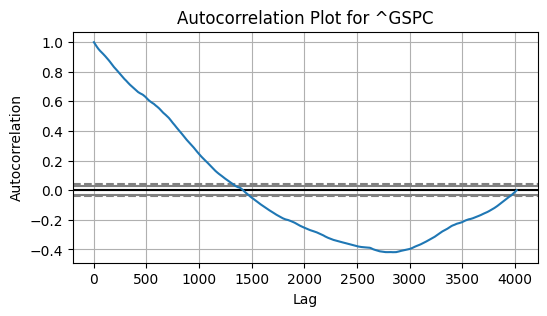

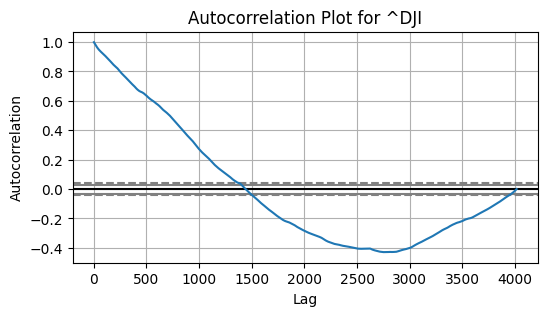

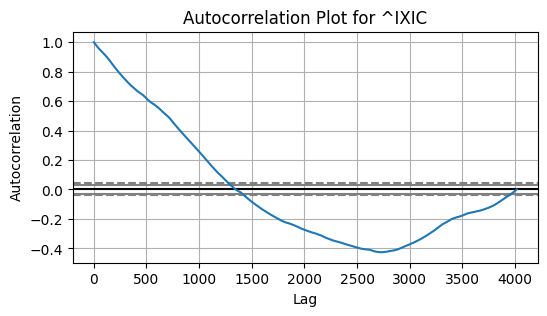

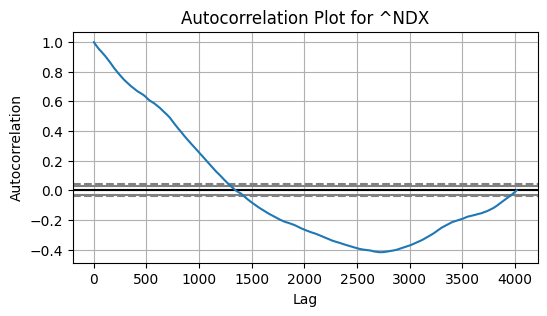

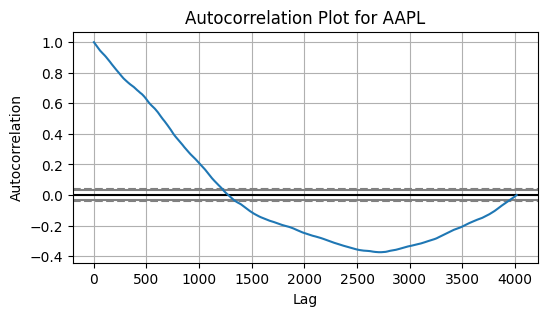

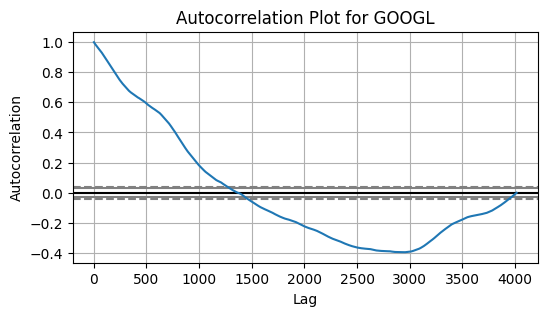

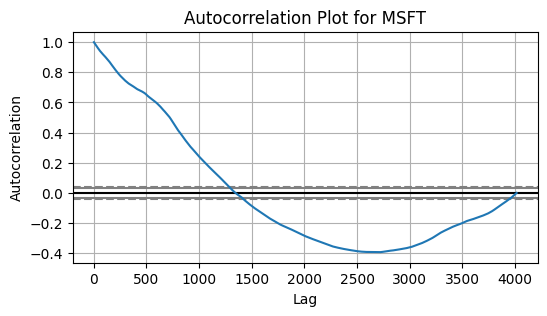

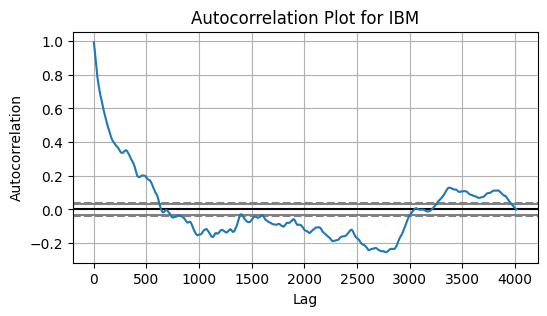

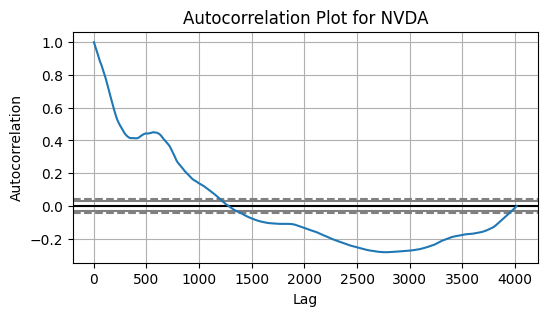

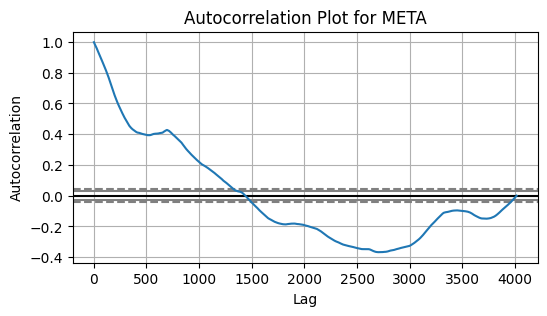

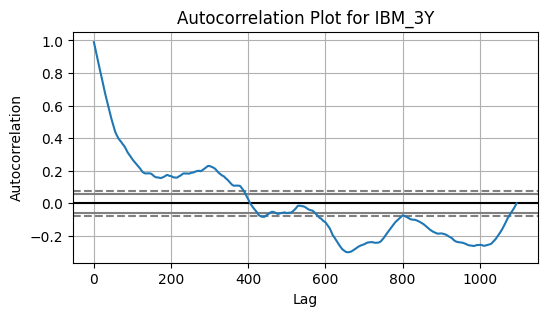

In [31]:
autocorr_plots(data)

correlation check ideas:  
Autocorrelation Function (ACF): The ACF plot can help identify seasonality. If there is significant seasonality, the ACF plot should show spikes at lags equal to the period.  
Statistical Tests: There are formal hypothesis tests available to detect seasonality, such as the Student T-Test and the Wilcoxon Signed Rank Test. These tests can be used to check if the observed seasonality is statistically significant.

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_acfs(stock_dict):
    for item, series in stock_dict.items():
        print(f"Plotting ACF for {item}")
        plot_acf(series)
        plt.show()


Plotting ACF for ^GSPC


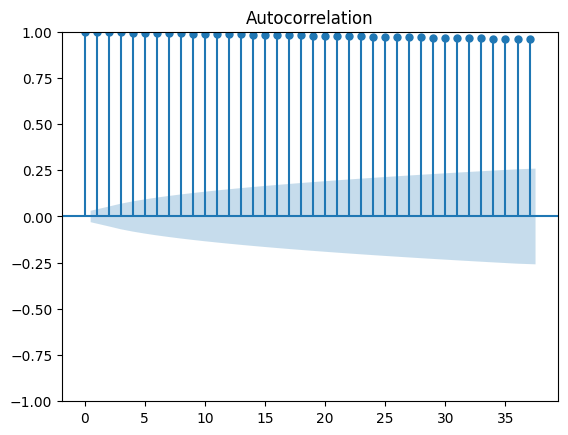

Plotting ACF for ^DJI


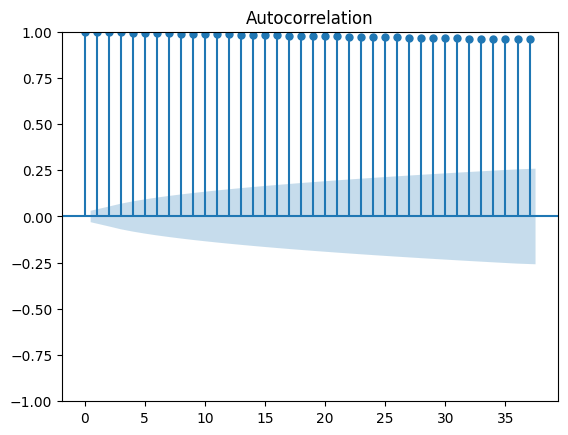

Plotting ACF for ^IXIC


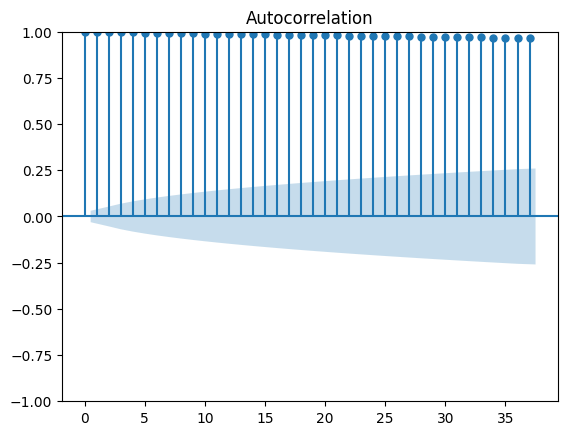

Plotting ACF for ^NDX


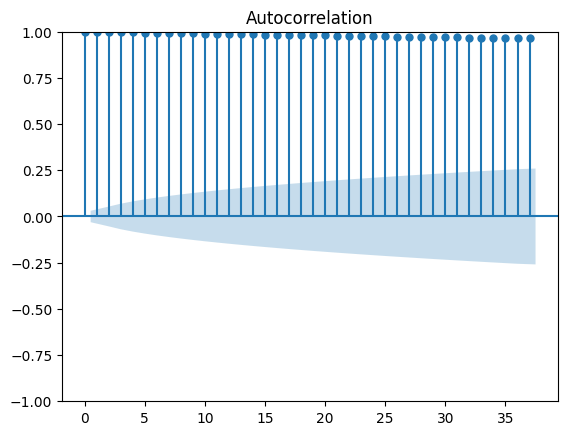

Plotting ACF for AAPL


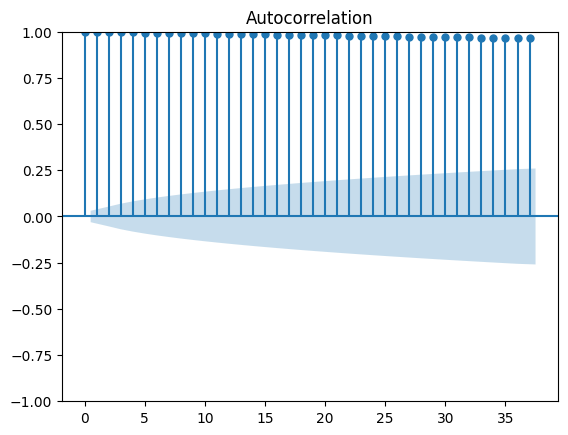

Plotting ACF for GOOGL


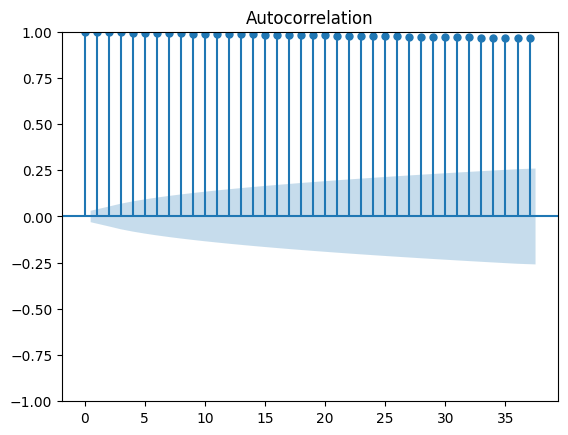

Plotting ACF for MSFT


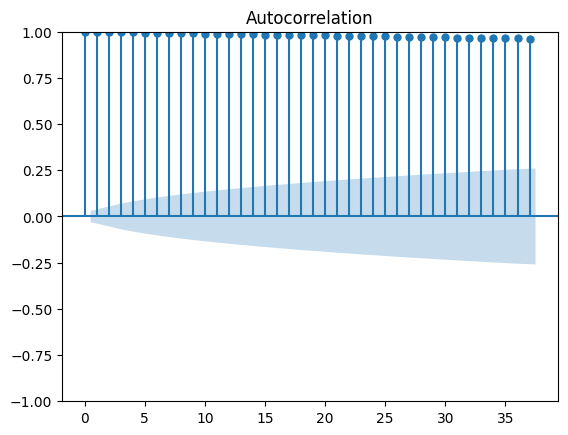

Plotting ACF for IBM


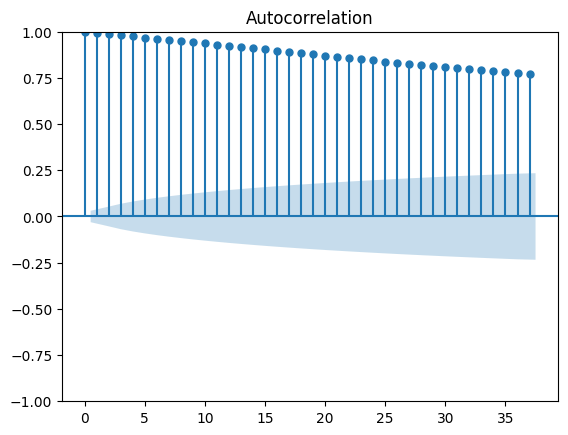

Plotting ACF for NVDA


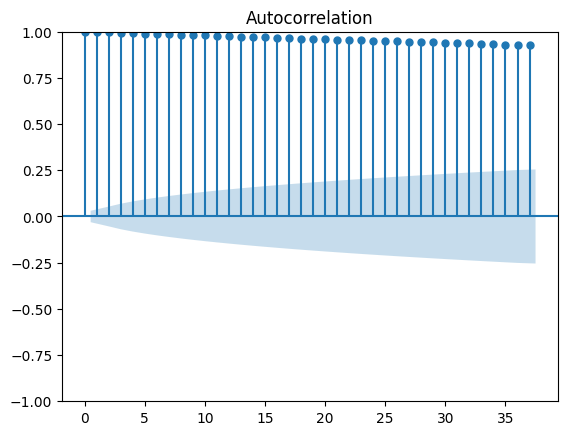

Plotting ACF for META


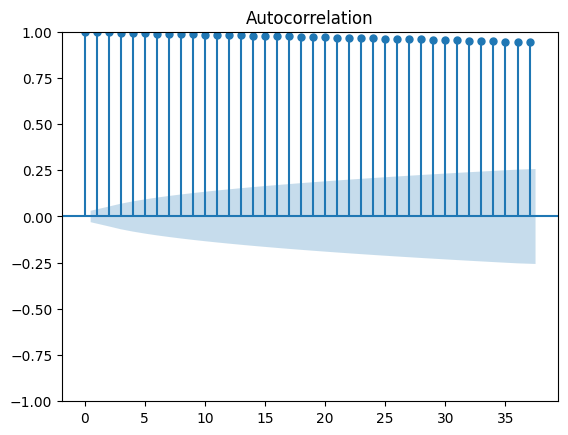

Plotting ACF for IBM_3Y


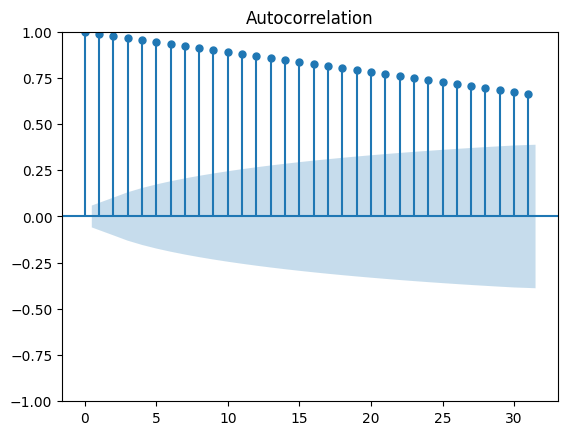

In [33]:
plot_acfs(data)

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf

def plot_pacfs(stock_dict):
    for item, series in stock_dict.items():
        print(f"Plotting PACF for {item}")
        plot_pacf(series)
        plt.show()


Plotting PACF for ^GSPC


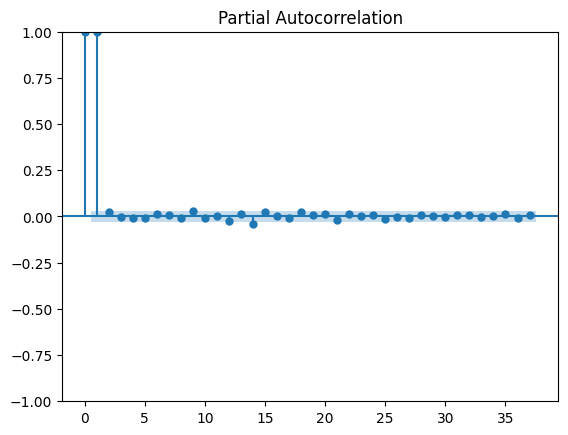

Plotting PACF for ^DJI


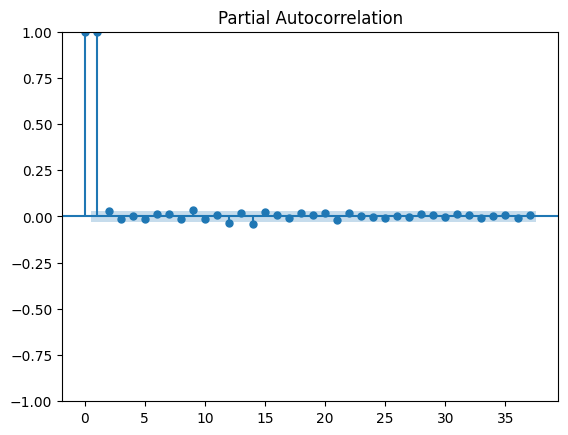

Plotting PACF for ^IXIC


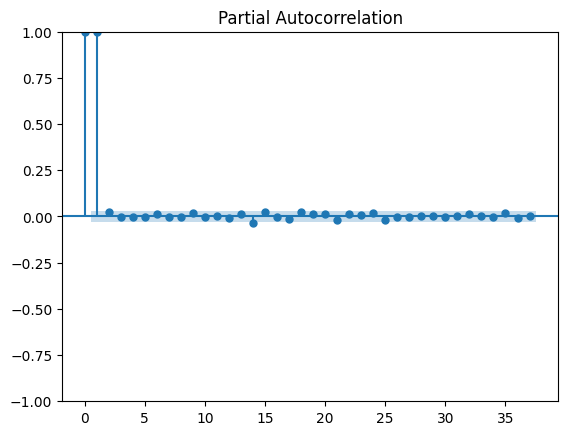

Plotting PACF for ^NDX


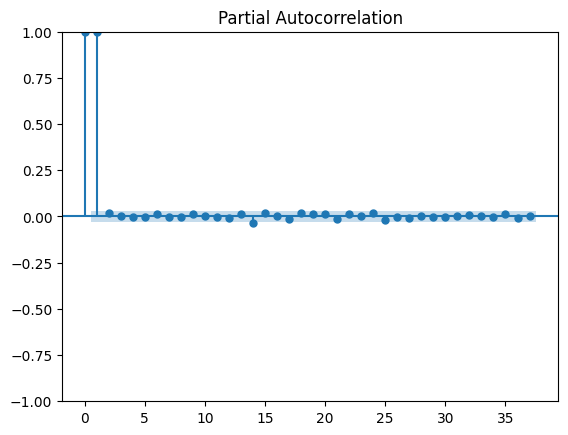

Plotting PACF for AAPL


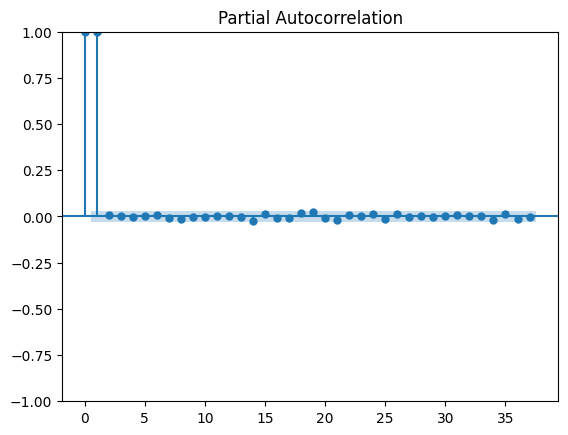

Plotting PACF for GOOGL


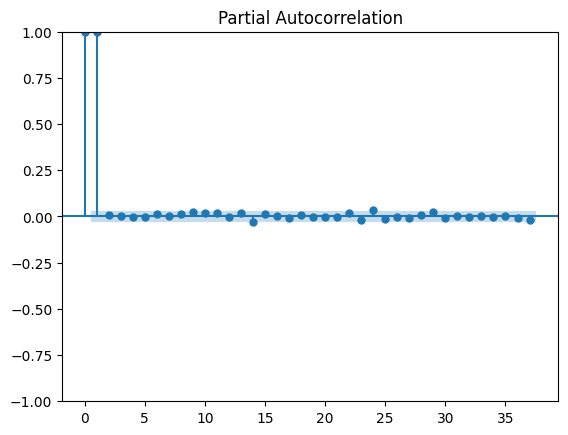

Plotting PACF for MSFT


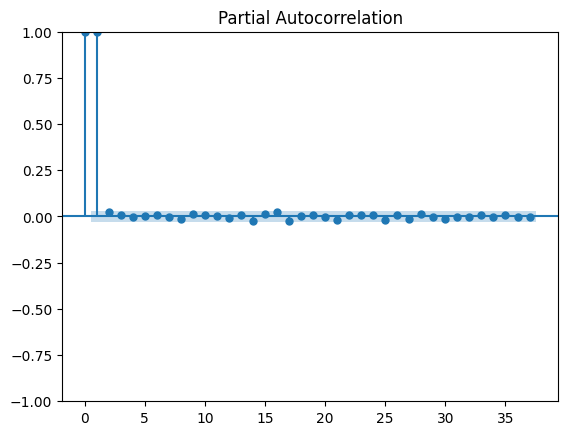

Plotting PACF for IBM


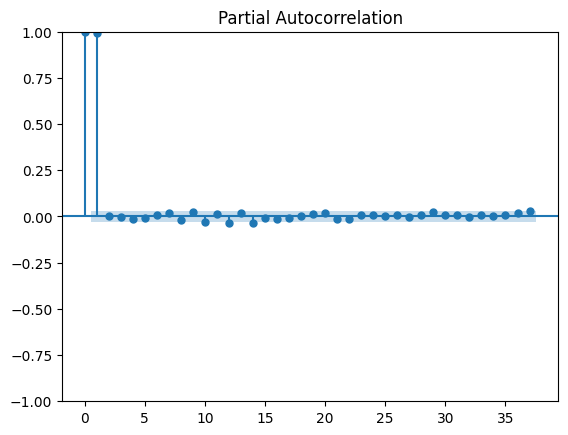

Plotting PACF for NVDA


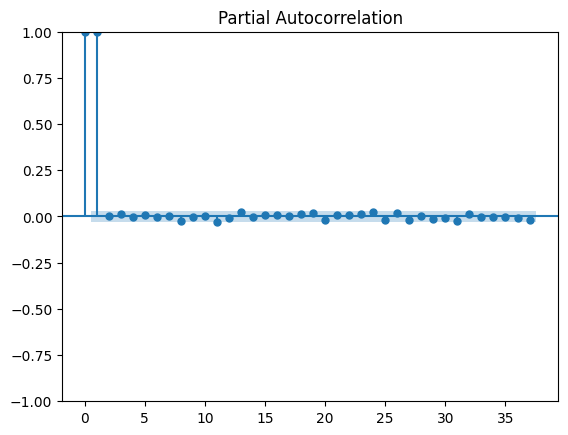

Plotting PACF for META


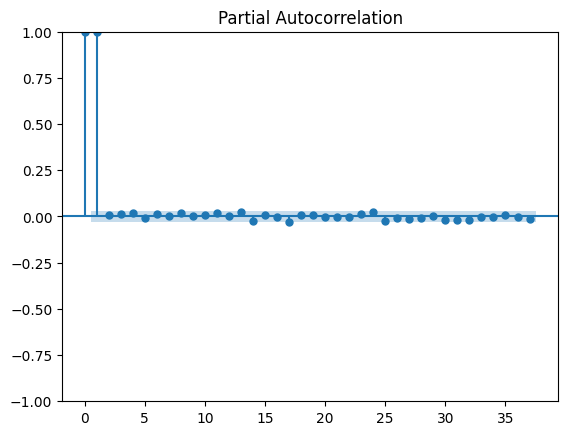

Plotting PACF for IBM_3Y


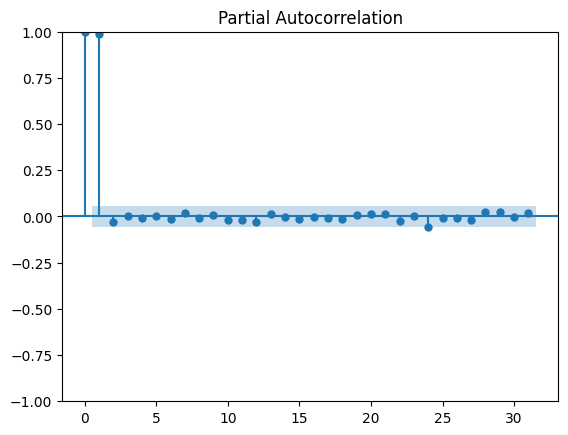

In [35]:
plot_pacfs(data)

## Train / Test Split --> Start "data" for testing

### temporal split

In [36]:
#data_ibm

In [37]:
data_ibm_all.index.freq, #y_transformed.index.freq,

(None,)

In [38]:
data_ibm_all.index.freq = 'D' # Set the frequency to daily

In [39]:
data_ibm_all.shape

(4014,)

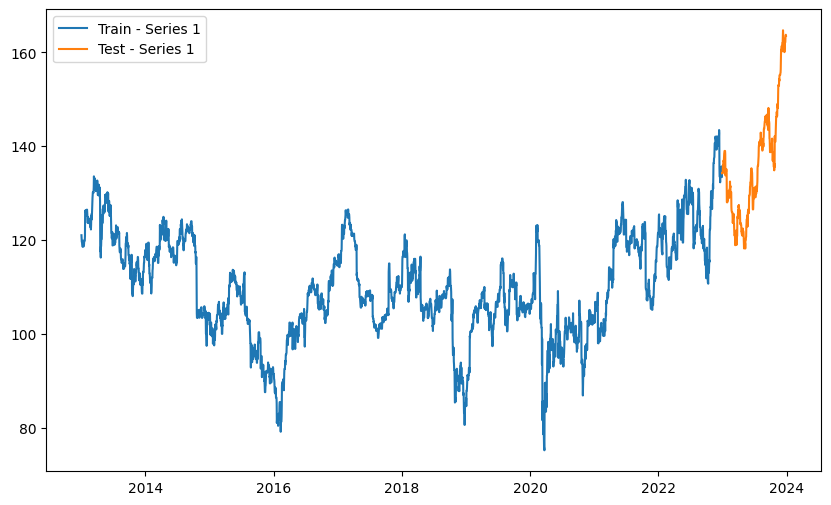

(2022-12-27    135.681366
 2022-12-28    133.394928
 2022-12-29    134.385712
 Freq: D, Name: Close, dtype: float64,
 2022-12-30    134.223755
 2022-12-31    134.223755
 2023-01-01    134.223755
 Freq: D, Name: Close, dtype: float64)

In [40]:
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

#y_train, y_test = temporal_train_test_split(y_transformed, test_size=90)
y_train, y_test = temporal_train_test_split(data_ibm_all, test_size=365)

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
#plt.plot(data_ibm, label='all')

plt.legend()
plt.show()

y_train.tail(3), y_test.head(3)

In [41]:
y_train.index.freq, y_test.index.freq,

(<Day>, <Day>)

## Converting non - stationary data to stationary. 
differencing, log transformation, or a Box-Cox transformation. 

Statistical stationarity: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past!   (Recall our famous forecasting quotes.)  The predictions for the stationarized series can then be "untransformed," by reversing whatever mathematical transformations were previously used, to obtain predictions for the original series. (The details are normally taken care of by your software.) Thus, finding the sequence of transformations needed to stationarize a time series often provides important clues in the search for an appropriate forecasting model.  Stationarizing a time series through differencing (where needed) is an important part of the process of fitting an ARIMA model, as discussed in the ARIMA pages of these notes.

Another reason for trying to stationarize a time series is to be able to obtain meaningful sample statistics such as means, variances, and correlations with other variables. Such statistics are useful as descriptors of future behavior only if the series is stationary. For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables. For this reason you should be cautious about trying to extrapolate regression models fitted to nonstationary data.

Most business and economic time series are far from stationary when expressed in their original units of measurement, and even after deflation or seasonal adjustment they will typically still exhibit trends, cycles, random-walking, and other non-stationary behavior.   If the series has a stable long-run trend and tends to revert to the trend line following a disturbance, it may be possible to stationarize it by de-trending (e.g., by fitting a trend line and subtracting it out prior to fitting a model, or else by including the time index as an independent variable in a regression or ARIMA model), perhaps in conjunction with logging or deflating.   Such a series is said to be trend-stationary.    However, sometimes even de-trending is not sufficient to make the series stationary, in which case it may be necessary to transform it into a series of period-to-period and/or season-to-season differences.  If the mean, variance, and autocorrelations of the original series are not constant in time, even after detrending, perhaps the statistics of the changes in the series between periods or between seasons will be constant.   Such a series is said to be difference-stationary.  (Sometimes it can be hard to tell the difference between a series that is trend-stationary and one that is difference-stationary, and a so-called unit root test may be used to get a more definitive answer.  We will return to this topic later in the course.)
(Return to top of page.)
source: https://people.duke.edu/~rnau/411diff.htm

In [42]:
from sktime.transformations.series.difference import Differencer

# Initialize the differencer
differencer = Differencer(lags=1, na_handling='fill_zero', memory='all') # Adjust the lags according to your needs

# Fit the differencer on the training data
differencer.fit(y_train)
#differencer.fit(data_ibm)

# Transform the training data
train_transformed = differencer.transform(y_train)

# Now, apply the same differencer to the testing data -- not needed for time series?
#test_transformed = differencer.transform(y_test)

#remove?
#y_transformed = differencer.transform(data_ibm)
#y_transformed_copy = y_transformed.copy() # needed?

#y_original = differencer.inverse_transform(y_transformed)




### transformation checks

In [75]:
data_ibm.index.freq, y_train.index.freq, train_transformed.index.freq

(<Day>, <Day>, <Day>)

In [76]:
y_train.head(5), train_transformed.head(5)# ,data_ibm.tail(5), y_original.tail(5)

(2013-01-02    121.021294
 2013-01-03    120.355652
 2013-01-04    119.566772
 2013-01-05    119.566772
 2013-01-06    119.566772
 Freq: D, Name: Close, dtype: float64,
 2013-01-02    0.000000
 2013-01-03   -0.665642
 2013-01-04   -0.788879
 2013-01-05    0.000000
 2013-01-06    0.000000
 Freq: D, Name: Close, dtype: float64)

In [77]:
y_train.tail(5), train_transformed.tail(5)# ,data_ibm.tail(5), y_original.tail(5)

(2022-12-25    134.947800
 2022-12-26    134.947800
 2022-12-27    135.681366
 2022-12-28    133.394928
 2022-12-29    134.385712
 Freq: D, Name: Close, dtype: float64,
 2022-12-25    0.000000
 2022-12-26    0.000000
 2022-12-27    0.733566
 2022-12-28   -2.286438
 2022-12-29    0.990784
 Freq: D, Name: Close, dtype: float64)

In [78]:
train_transformed.describe()

count    3649.000000
mean        0.003662
std         1.300532
min       -12.025108
25%        -0.334732
50%         0.000000
75%         0.433075
max         9.217438
Name: Close, dtype: float64

In [47]:
# check errors not working with latest data
#adf_panel_results = adf_test(train_transformed)
#adf_panel_results

### Visualization on stationary data - check differencing

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Close'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

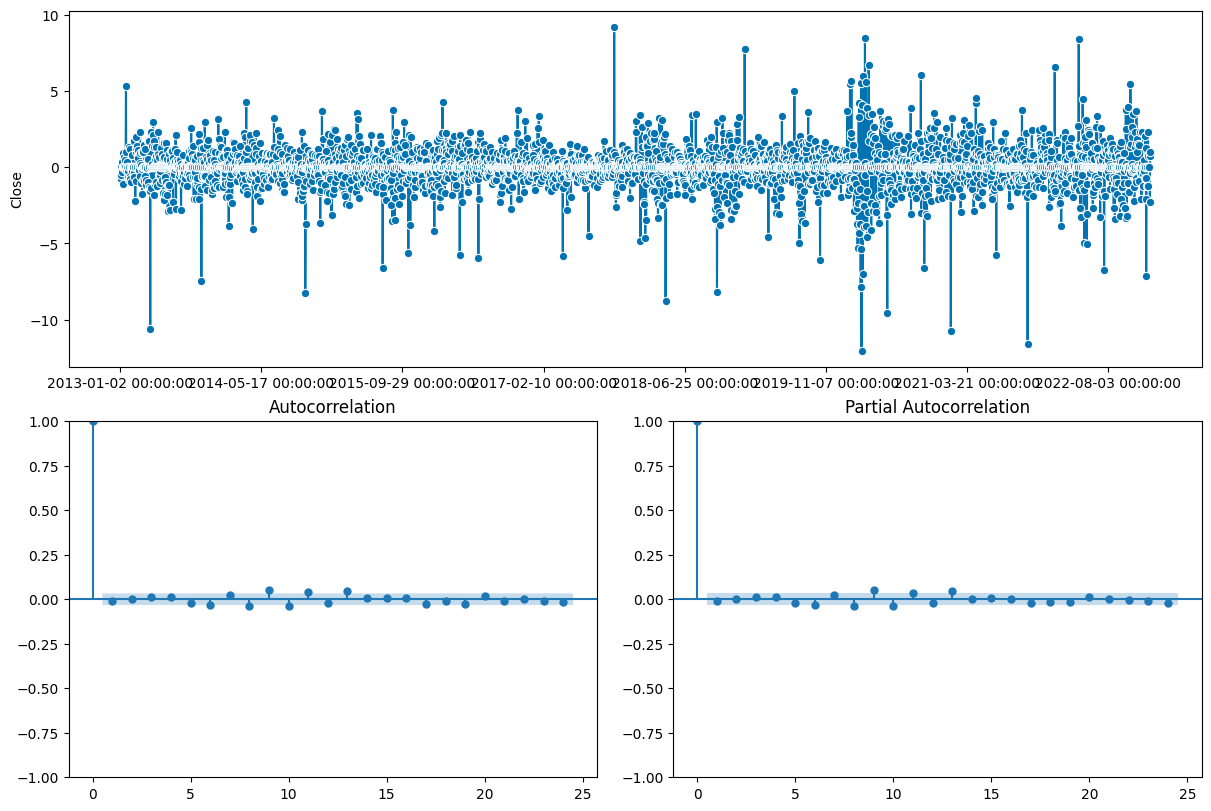

In [83]:
plot_correlations(train_transformed)

In [84]:
#plot_time_series(train_transformed)

In [49]:
#autocorr_plots(train_transformed)

In [50]:
#plot_acfs(train_transformed)

In [51]:
#plot_pacfs(train_transformed)

## Evaluation Metrics & plotting functions:

In [85]:
# create new model scoring dataframe to save scores:

model_scoring = pd.DataFrame({
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'MAPE': []
})


In [86]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd

def calculate_error_metrics(model_name, y_test, y_pred):
    # Calculate the errors
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Create a DataFrame with the results
    df = pd.DataFrame({
        'Model': [model_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape]
    })
    #scoring_df = scoring_df.append(df, ignore_index=True)
    #scoring_df = scoring_df.append(df, ignore_index=True)

    #display(df)
    
    return df


In [87]:
from sktime.performance_metrics.forecasting import MeanSquaredError
import numpy as np

class RootMeanSquaredError_(MeanSquaredError):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def score(self, y_true, y_pred):
        mse = super().score(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse


In [88]:
#y_test.describe()

In [89]:
#y_pred.describe()

In [90]:
#calculate_errors('model', y_test, y_pred)

RMSE MAE MAPE ME MPE

In [91]:
# evaluate (?)

In [92]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_and_print_prediction(y_train, y_test, y_pred, train_days_show=len(y_train)):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    plt.figure(figsize=(10, 6))
    plt.plot(y_train.iloc[-train_days_show:].index, y_train.iloc[-train_days_show:], label='Train - Series 1')
    plt.plot(y_test.index, y_test, label='Test - Series 1')
    plt.plot(y_pred.index, y_pred, label='predictions - Series 1')

    # Format x-axis to display dates
    ax = plt.gca()
    date_format = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(date_format)

    # Add gridlines for each year
    ax = plt.gca()
    ax.xaxis.set_minor_locator(mdates.YearLocator())
    ax.grid(True, which='both')

    plt.legend()
    plt.show()

    print(y_pred.iloc[0])


## Model building part i: classic statistics

For example, in python and R, the auto ARIMA method itself will generate the optimal p and q parameters, which would be suitable for the data set to provide better forecasting. The high-level logic behind that is the same as the logic behind hyperparameter tuning of any other machine learning model. We need to try some combinations of p and q parameters and compare results using a validation set.

Since our search space is not big, usually values p and q are not higher than 10, we can apply a popular technique for hyperparameter optimization called grid search. Grid search is simply an exhaustive search through a manually specified subset of the hyperparameter space of a learning algorithm. Basically, it means that this method will try each combination of p and q from the specified subset that we provided.  
source: https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling#:~:text=The%20autocorrelation%20function%20(ACF)%20is,number%20of%20periods%20or%20units.

In [60]:
# ARIMA + gridearch SARIMA?

In [61]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [62]:
# check multiple train test splits from sktime!
#https://towardsdatascience.com/build-complex-time-series-regression-pipelines-with-sktime-910bc25c96b6

In [96]:
predictions_df = pd.DataFrame(index=y_test.index)
#predictions_df = pd.concat([predictions_df, y_test], axis=1)
predictions_df['y_test'] = y_test.values
predictions_df.head()

y_test
2022-12-30  134.223755
2022-12-31  134.223755
2023-01-01  134.223755
2023-01-02  134.223755
2023-01-03  134.852524

In [183]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_evaluation import evaluate

from sktime.forecasting.base import ForecastingHorizon

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing


from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ExpandingWindowSplitter


### (t0) simple moving average model (SMA) using sktime naive forecaster + gridsearch

{'window_length': 90}


mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                                0.073388       0.001239        0.001652   
1                                0.073386       0.001101        0.001667   
2                                0.073333       0.001218        0.001619   
3                                0.072173       0.001166        0.001565   
4                                0.071796       0.001170        0.001598   
5                                0.070544       0.001180        0.001734   
6                                0.069295       0.001330        0.001760   
7                                0.067599       0.001204        0.001599   
8                                0.066197       0.000779        0.000992   
9                                0.066031       0.000776        0.000974   
10                               0.063662       0.000731        0.000956   

                   params  rank_test_MeanAbsolutePercentageError  
0    {'window_length': 2}                                   11.0  
1    {'window_length': 3}                                   10.0  
2    {'window_length': 5}                                    9.0  
3    {'window_length': 9}                                    8.0  
4   {'window_length': 10}                                    7.0  
5   {'window_length': 15}                                    6.0  
6   {'window_length': 20}                                    5.0  
7   {'window_length': 30}                                    4.0  
8   {'window_length': 45}                                    3.0  
9   {'window_length': 60}                                    2.0  
10  {'window_length': 90}                                    1.0

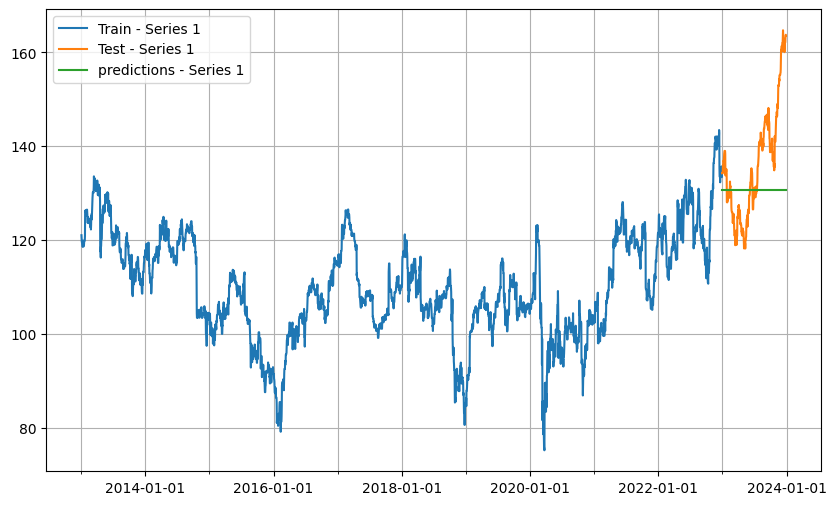

130.62740597195096


In [136]:
param_grid = {
    'window_length': [2, 3, 5, 9, 10, 15, 20, 30, 45, 60, 90]
}

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, fh=90)

model = NaiveForecaster(strategy='mean', sp=1) #Seasonal periodicity to use in the seasonal forecasting. None=1.

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(y_train)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = grid_search.predict(fh_n)
#y_original = differencer.inverse_transform(y_transformed)

# Access the cross-validation results
cv_results = grid_search.cv_results_
display(cv_results)
plot_and_print_prediction(y_train, y_test, y_pred)

In [99]:
# error metrics:
model_name = 'SMA_gscv_win90_t0'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0  SMA_gscv_win90_t0  13.083018  10.022836  0.070315

In [137]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0
2022-12-30  134.223755         134.223755
2022-12-31  134.223755         134.223755
2023-01-01  134.223755         134.223755
2023-01-02  134.223755         134.223755
2023-01-03  134.852524         134.852524

In [175]:
# testing; drop col
#model_scoring.drop(index=9, inplace=True)
#model_scoring

In [100]:
#type(y_pred)
y_pred.index.freq
#diff_data_ibm.index.freq = 'D' # Set the frequency to daily


<Day>

In [ ]:
# also add evaluate -=-

### (t1) simple moving average model (SMA) using sktime naive forecaster + gridsearch

{'window_length': 90}


mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                            3.205713e+14       0.001205        0.001633   
1                            4.669174e+14       0.001159        0.001601   
2                            6.804390e+14       0.001170        0.001712   
3                            5.465279e+14       0.001372        0.001638   
4                            5.110511e+14       0.001154        0.001543   
5                            4.482311e+14       0.001314        0.001823   
6                            3.562592e+14       0.001154        0.001688   
7                            2.696623e+14       0.001172        0.001597   
8                            1.951821e+14       0.000762        0.001010   
9                            1.779478e+14       0.000740        0.000991   
10                           1.069470e+14       0.000736        0.000951   

                   params  rank_test_MeanAbsolutePercentageError  
0    {'window_length': 2}                                    5.0  
1    {'window_length': 3}                                    8.0  
2    {'window_length': 5}                                   11.0  
3    {'window_length': 9}                                   10.0  
4   {'window_length': 10}                                    9.0  
5   {'window_length': 15}                                    7.0  
6   {'window_length': 20}                                    6.0  
7   {'window_length': 30}                                    4.0  
8   {'window_length': 45}                                    3.0  
9   {'window_length': 60}                                    2.0  
10  {'window_length': 90}                                    1.0

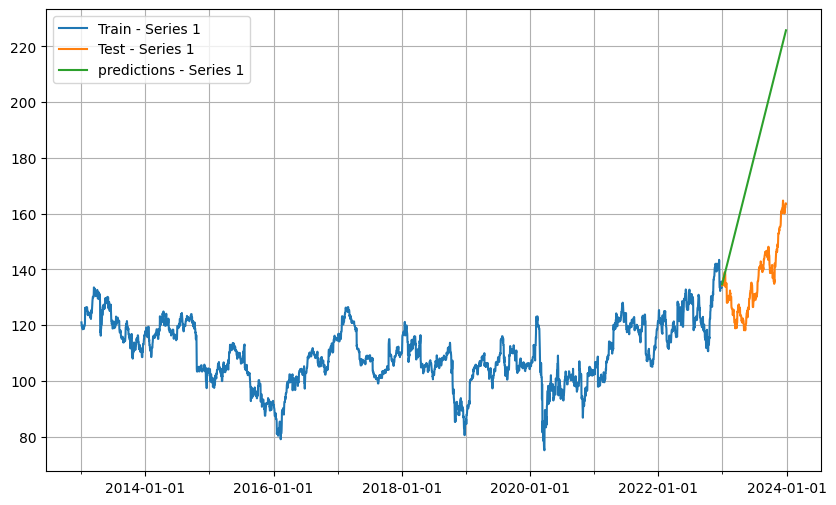

134.63605456882053


In [256]:
param_grid = {
    'window_length': [2, 3, 5, 9, 10, 15, 20, 30, 45, 60, 90]
}

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, fh=90)

model = NaiveForecaster(strategy='mean', sp=1) #Seasonal periodicity to use in the seasonal forecasting. None=1.

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(train_transformed)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = grid_search.predict(fh_n)

y_pred = differencer.inverse_transform(y_pred_transformed)

# Access the cross-validation results
cv_results = grid_search.cv_results_
display(cv_results)
plot_and_print_prediction(y_train, y_test, y_pred)

In [140]:
# error metrics:
model_name = 'SES_gscv_trend0_s00_sp365_t1'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0               SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1               SMA_gscv_win90_t1  47.875986  44.109975  0.321189
2  SES_gscv_damp0_trend0_sp365_t0  12.003485   9.616440  0.069203
3             SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
4    SES_gscv_trend0_s00_sp365_t1  11.626932   9.350516  0.067629
5               SMA_gscv_win90_t1  47.875986  44.109975  0.321189

In [141]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SMA_gscv_win90_t1
2022-12-30  134.223755         134.223755         134.223755
2022-12-31  134.223755         134.223755         134.223755
2023-01-01  134.223755         134.223755         134.223755
2023-01-02  134.223755         134.223755         134.223755
2023-01-03  134.852524         134.852524         134.852524

### t(0) simple exponential smoothing (SES) * gridsearch 

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/_smoothers.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  b = (b - lb) / (ub - lb)
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/_smoothers.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  b = (b - lb) / (ub - lb)
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/_smoothers.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  b = (b - lb) / (ub - lb)
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/_smoothers.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  b = (b - lb) / (ub - lb)
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/pyth

{'smoothing_level': 0.9, 'sp': 365, 'trend': None}


/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                                 0.148628       0.022620        0.015588   
1                                      NaN       0.036267        0.016782   
2                                 0.119864       0.005884        0.005082   
3                                 0.148628       0.022181        0.014327   
4                                      NaN       0.037201        0.015641   
..                                     ...            ...             ...   
115                               0.068864       0.047694        0.016108   
116                               0.066575       0.004929        0.004025   
117                               0.067098       0.021334        0.018884   
118                               0.068864       0.042664        0.011649   
119                               0.066575       0.005290        0.005709   

                                                params  \
0    {'smoothing_level': 0.0, 'sp': 365, 'trend': '...   
1    {'smoothing_level': 0.0, 'sp': 365, 'trend': '...   
2    {'smoothing_level': 0.0, 'sp': 365, 'trend': N...   
3    {'smoothing_level': 0.0, 'sp': 12, 'trend': 'a...   
4    {'smoothing_level': 0.0, 'sp': 12, 'trend': 'm...   
..                                                 ...   
115  {'smoothing_level': 0.9, 'sp': 1, 'trend': 'mul'}   
116   {'smoothing_level': 0.9, 'sp': 1, 'trend': None}   
117  {'smoothing_level': 0.9, 'sp': 2, 'trend': 'add'}   
118  {'smoothing_level': 0.9, 'sp': 2, 'trend': 'mul'}   
119   {'smoothing_level': 0.9, 'sp': 2, 'trend': None}   

     rank_test_MeanAbsolutePercentageError  
0                                    106.5  
1                                      NaN  
2                                     94.5  
3                                    106.5  
4                                      NaN  
..                                     ...  
115                                   30.5  
116                                    2.5  
117                                    6.5  
118                                   30.5  
119                                    2.5  

[120 rows x 5 columns]

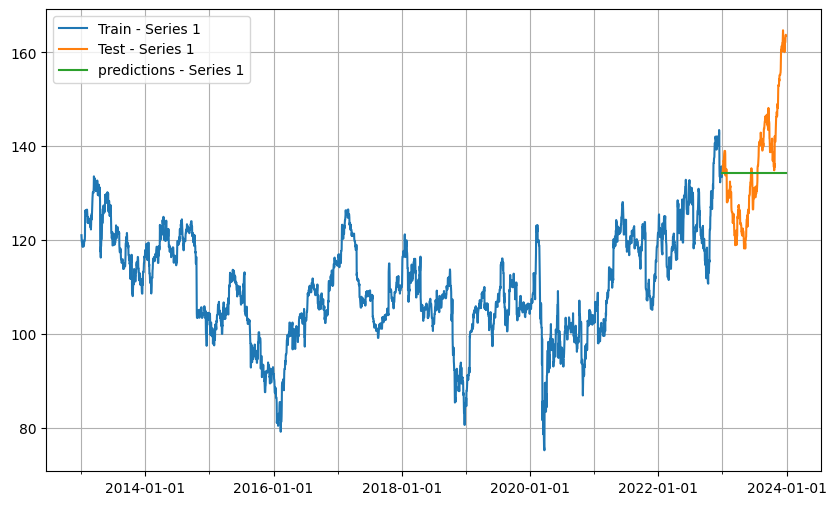

134.30876405199183


In [142]:
#'sp': [365, 12, 1, 2] #4, 6, 8
param_grid = {
    'trend': ['add', 'mul', None],
    'damped_trend': [True, False],
    'sp': [365, 12, 1, 2],
    'smoothing_level': [0.0, 0.2, 0.5]
}

param_grid = {
    'smoothing_level': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'sp': [365, 12, 1, 2],
    'trend': ['add', 'mul', None]
}

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, step_length=30, fh=90)

model = ExponentialSmoothing() #(can use box-cox).

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(y_train)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = grid_search.predict(fh_n)

# Access the cross-validation results
cv_results = grid_search.cv_results_
display(cv_results)
plot_and_print_prediction(y_train, y_test, y_pred)

In [145]:
# error metrics:
#'SES_gscv_damp0_trend0_sp365_t0'
model_name = 'SES_gscv_alpha09_t0'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE       MAE      MAPE
0  SES_gscv_alpha09_t0  12.013235  9.618793  0.069187

In [146]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SMA_gscv_win90_t1  \
2022-12-30  134.223755         134.223755         134.223755   
2022-12-31  134.223755         134.223755         134.223755   
2023-01-01  134.223755         134.223755         134.223755   
2023-01-02  134.223755         134.223755         134.223755   
2023-01-03  134.852524         134.852524         134.852524   

            SES_gscv_alpha09_t0  
2022-12-30           134.223755  
2022-12-31           134.223755  
2023-01-01           134.223755  
2023-01-02           134.223755  
2023-01-03           134.852524

### --> t(1) simple exponential smoothing (SES) * gridsearch 

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster ExponentialSmoothing failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=3270.
                The score will be set to nan.
                Failed forecaster with parameters: ExponentialSmoothing(smoothing_level=0.0, sp=1, trend='mul').
                
  ret = [fun(x, meta=meta) for x in iter]
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster ExponentialSmoothing failed,
                you can set error_score='raise' in evaluate to see
                the excep

{'smoothing_level': 0.0, 'sp': 365, 'trend': None}


mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                             2.967098e+13       0.029130        0.021095   
1                                      NaN            NaN             NaN   
2                             1.912995e+12       0.009847        0.005375   
3                             2.967098e+13       0.031006        0.018729   
4                                      NaN            NaN             NaN   
..                                     ...            ...             ...   
115                                    NaN            NaN             NaN   
116                           6.569606e+14       0.005488        0.005348   
117                           6.734153e+14       0.019337        0.012563   
118                                    NaN            NaN             NaN   
119                           6.569606e+14       0.003333        0.003793   

                                                params  \
0    {'smoothing_level': 0.0, 'sp': 365, 'trend': '...   
1    {'smoothing_level': 0.0, 'sp': 365, 'trend': '...   
2    {'smoothing_level': 0.0, 'sp': 365, 'trend': N...   
3    {'smoothing_level': 0.0, 'sp': 12, 'trend': 'a...   
4    {'smoothing_level': 0.0, 'sp': 12, 'trend': 'm...   
..                                                 ...   
115  {'smoothing_level': 0.9, 'sp': 1, 'trend': 'mul'}   
116   {'smoothing_level': 0.9, 'sp': 1, 'trend': None}   
117  {'smoothing_level': 0.9, 'sp': 2, 'trend': 'add'}   
118  {'smoothing_level': 0.9, 'sp': 2, 'trend': 'mul'}   
119   {'smoothing_level': 0.9, 'sp': 2, 'trend': None}   

     rank_test_MeanAbsolutePercentageError  
0                                      6.5  
1                                      NaN  
2                                      2.5  
3                                      6.5  
4                                      NaN  
..                                     ...  
115                                    NaN  
116                                   70.5  
117                                   78.5  
118                                    NaN  
119                                   70.5  

[120 rows x 5 columns]

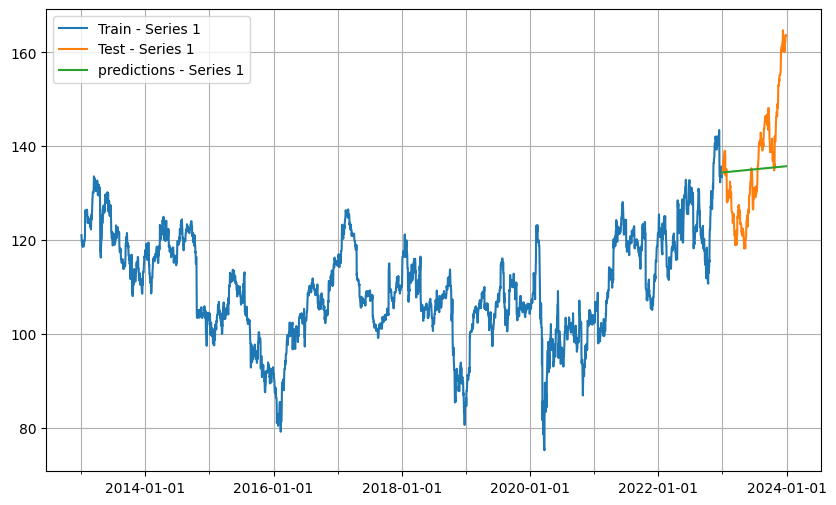

134.3893740966168


In [344]:
param_grid = {
    'smoothing_level': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'sp': [365, 12, 1, 2],
    'trend': ['add', 'mul', None]
}

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, step_length=15, fh=90)

model = ExponentialSmoothing() #(can use box-cox).

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(train_transformed)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = grid_search.predict(fh_n)

y_pred = differencer.inverse_transform(y_pred_transformed)

# Access the cross-validation results
cv_results = grid_search.cv_results_
display(cv_results)
plot_and_print_prediction(y_train, y_test, y_pred)

In [258]:
grid_search.best_params_

{'smoothing_level': 0.0, 'sp': 365, 'trend': None}

In [134]:
# error metrics:
model_name = 'SES_gscv_trend0_s00_sp365_t1'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0               SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1               SMA_gscv_win90_t1  47.875986  44.109975  0.321189
2  SES_gscv_damp0_trend0_sp365_t0  12.003485   9.616440  0.069203
3             SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
4    SES_gscv_trend0_s00_sp365_t1  11.626932   9.350516  0.067629

In [259]:
#storing predictions
model_name = 'SES_gscv_trend0_s00_sp365_t1'
predictions_df[model_name] = y_pred.values
predictions_df.head()

y_test  SES_gscv_trend0_s00_sp365_t1
2022-12-30  134.223755                    134.389374
2022-12-31  134.223755                    134.393037
2023-01-01  134.223755                    134.396699
2023-01-02  134.223755                    134.400361
2023-01-03  134.852524                    134.404024

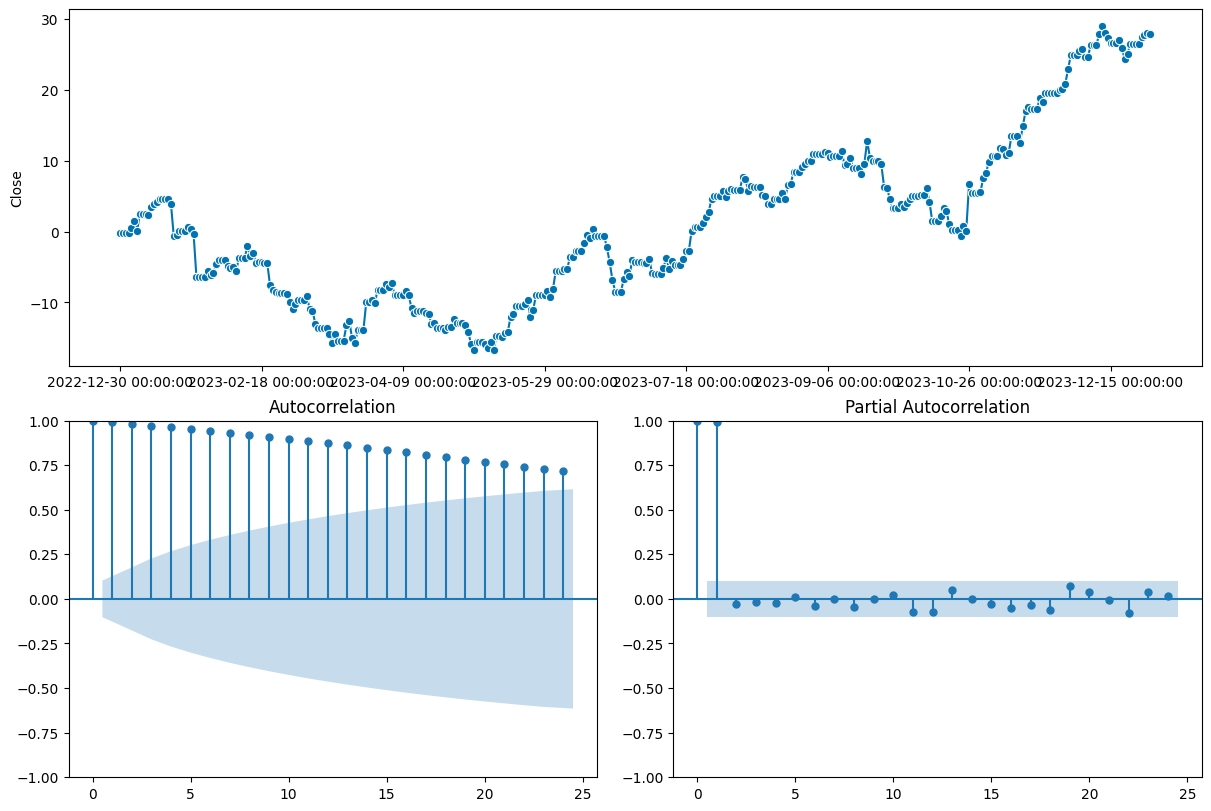

In [345]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


In [210]:
from sktime.forecasting.model_evaluation import evaluate

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, fh=90)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

df = evaluate(forecaster=model, y=y_train, cv=cv, strategy="refit", return_data=True)

#df.iloc[:, :5]
df.describe()

test_MeanAbsolutePercentageError    fit_time   pred_time  \
count                        290.000000  290.000000  290.000000   
mean                           0.073437    0.003597    0.002815   
min                            0.001240    0.003219    0.002358   
25%                            0.036603    0.003322    0.002419   
50%                            0.066899    0.003399    0.002503   
75%                            0.107997    0.003458    0.002887   
max                            0.173000    0.023680    0.029914   
std                            0.047326    0.001451    0.001682   

       len_train_window               cutoff  
count        290.000000                  290  
mean        3414.500000  2022-05-08 12:00:00  
min         3270.000000  2021-12-15 00:00:00  
25%         3342.250000  2022-02-25 06:00:00  
50%         3414.500000  2022-05-08 12:00:00  
75%         3486.750000  2022-07-19 18:00:00  
max         3559.000000  2022-09-30 00:00:00  
std           83.860002                  NaN

In [212]:
from sktime.forecasting.model_evaluation import evaluate

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, fh=90)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

df = evaluate(forecaster=model, y=y_train, cv=cv, strategy="refit", return_data=True)

#df.iloc[:, :5]
df.describe()

test_MeanAbsolutePercentageError    fit_time   pred_time  \
count                        290.000000  290.000000  290.000000   
mean                           0.073437    0.003504    0.002543   
min                            0.001240    0.003214    0.002363   
25%                            0.036603    0.003394    0.002458   
50%                            0.066899    0.003445    0.002495   
75%                            0.107997    0.003505    0.002534   
max                            0.173000    0.009706    0.006130   
std                            0.047326    0.000426    0.000274   

       len_train_window               cutoff  
count        290.000000                  290  
mean        3414.500000  2022-05-08 12:00:00  
min         3270.000000  2021-12-15 00:00:00  
25%         3342.250000  2022-02-25 06:00:00  
50%         3414.500000  2022-05-08 12:00:00  
75%         3486.750000  2022-07-19 18:00:00  
max         3559.000000  2022-09-30 00:00:00  
std           83.860002                  NaN

  
  Testing with parameters  
    

#### stats tests wip

In [349]:
#from statsmodels.stats.diagnostic import durbin_wu_test

#dw_stat, p_value = durbin_wu_test(residuals)
#print("Durbin-Watson statistic:", dw_stat)


In [347]:
from scipy.stats import jarque_bera

jb_stat, p_value = jarque_bera(residuals)
print("Jarque-Bera statistic:", jb_stat)


Jarque-Bera statistic: 25.85328879200013


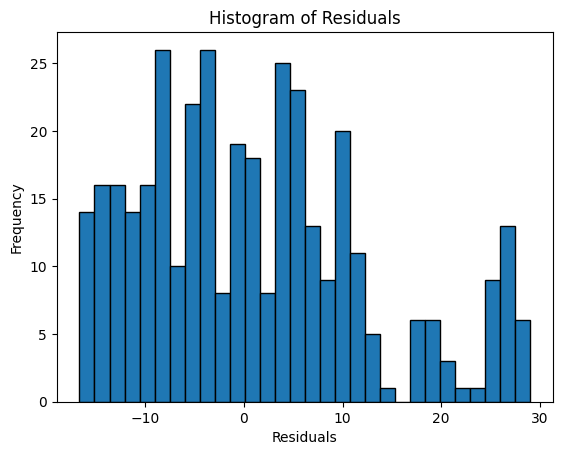

In [350]:
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


### Prophet and randomized search

#### --> t(0) Prophet

18:27:34 - cmdstanpy - INFO - Chain [1] start processing
18:27:34 - cmdstanpy - INFO - Chain [1] done processing


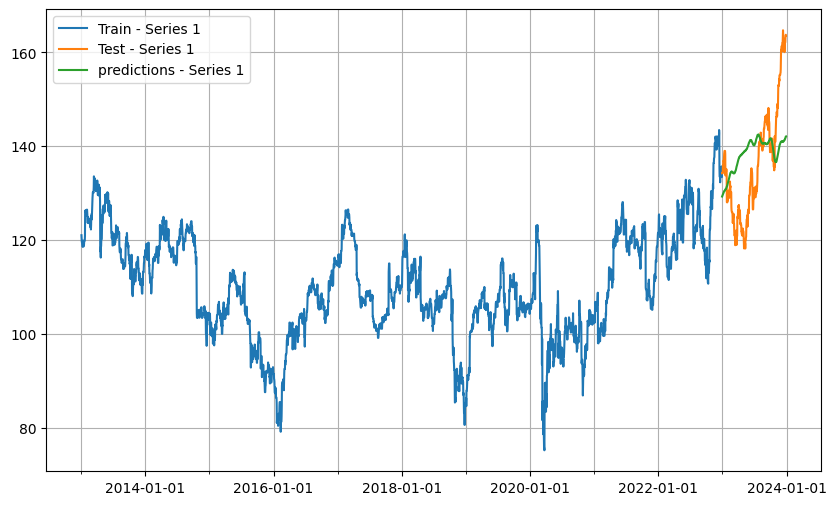

129.2667564479455


In [260]:
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon

# Create a new Prophet object
model = Prophet()

# Fit the model to the data
model.fit(y_train)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = model.predict(fh_n)

# scores

plot_and_print_prediction(y_train, y_test, y_pred)

In [205]:
from sktime.forecasting.model_evaluation import evaluate

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, fh=90)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

df = evaluate(forecaster=model, y=y_train, cv=cv, strategy="refit", return_data=True)

#df.iloc[:, :5]
df.describe()

17:43:00 - cmdstanpy - INFO - Chain [1] start processing
17:43:01 - cmdstanpy - INFO - Chain [1] done processing
17:43:01 - cmdstanpy - INFO - Chain [1] start processing
17:43:01 - cmdstanpy - INFO - Chain [1] done processing
17:43:01 - cmdstanpy - INFO - Chain [1] start processing
17:43:02 - cmdstanpy - INFO - Chain [1] done processing
17:43:02 - cmdstanpy - INFO - Chain [1] start processing
17:43:03 - cmdstanpy - INFO - Chain [1] done processing
17:43:03 - cmdstanpy - INFO - Chain [1] start processing
17:43:03 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:05 - cmdstanpy - INFO - Chain [1] done processing
17:43:05 - cmdstanpy - INFO - Chain [1] start processing
17:43:06 - cmdstanpy - INFO - Chain [1] done processing
17:43:06 - cmdstanpy - INFO - Chain [1] start processing
17:43:07 - cmdstanpy - INFO - Chain [1]

test_MeanAbsolutePercentageError    fit_time   pred_time  \
count                        290.000000  290.000000  290.000000   
mean                           0.069407    0.830160    0.017983   
min                            0.000242    0.457377    0.012133   
25%                            0.038868    0.740853    0.012528   
50%                            0.065605    0.823217    0.012745   
75%                            0.100370    0.919135    0.013785   
max                            0.181820    1.257492    0.148889   
std                            0.042219    0.130484    0.015843   

       len_train_window               cutoff  
count        290.000000                  290  
mean        3414.500000  2022-05-08 12:00:00  
min         3270.000000  2021-12-15 00:00:00  
25%         3342.250000  2022-02-25 06:00:00  
50%         3414.500000  2022-05-08 12:00:00  
75%         3486.750000  2022-07-19 18:00:00  
max         3559.000000  2022-09-30 00:00:00  
std           83.860002                  NaN

In [154]:
# error metrics:
model_name = 'Prophet_param0_t0'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0               SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1               SMA_gscv_win90_t1  47.875986  44.109975  0.321189
2  SES_gscv_damp0_trend0_sp365_t0  12.003485   9.616440  0.069203
3             SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
4    SES_gscv_trend0_s00_sp365_t1  11.626932   9.350516  0.067629
5               SMA_gscv_win90_t1  47.875986  44.109975  0.321189
6               Prophet_param0_t0  11.321214   9.437574  0.070089

In [261]:
#storing predictions
model_name = 'Prophet_param0_t0'
predictions_df[model_name] = y_pred.values
predictions_df.head()

y_test  SES_gscv_trend0_s00_sp365_t1  Prophet_param0_t0
2022-12-30  134.223755                    134.389374         129.266756
2022-12-31  134.223755                    134.393037         129.373010
2023-01-01  134.223755                    134.396699         129.477661
2023-01-02  134.223755                    134.400361         129.636592
2023-01-03  134.852524                    134.404024         129.723931

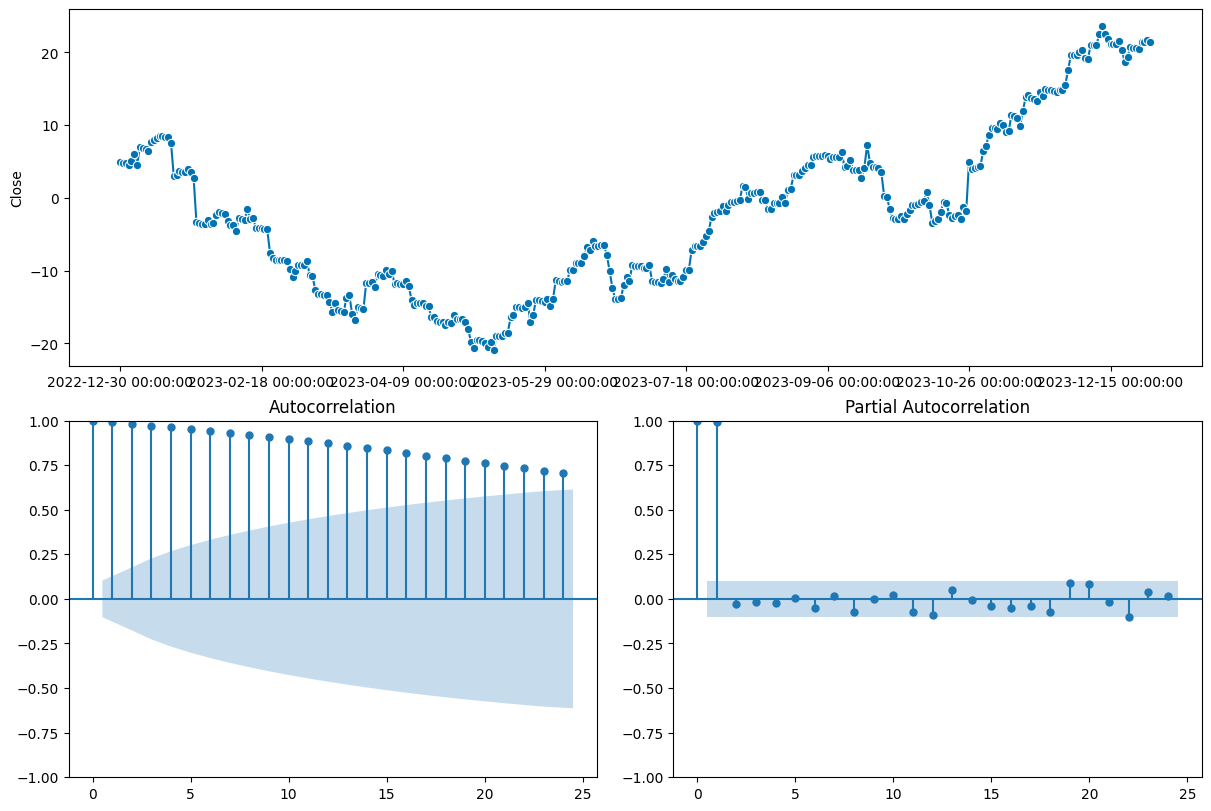

In [156]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


#### t(1) Prophet

17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing


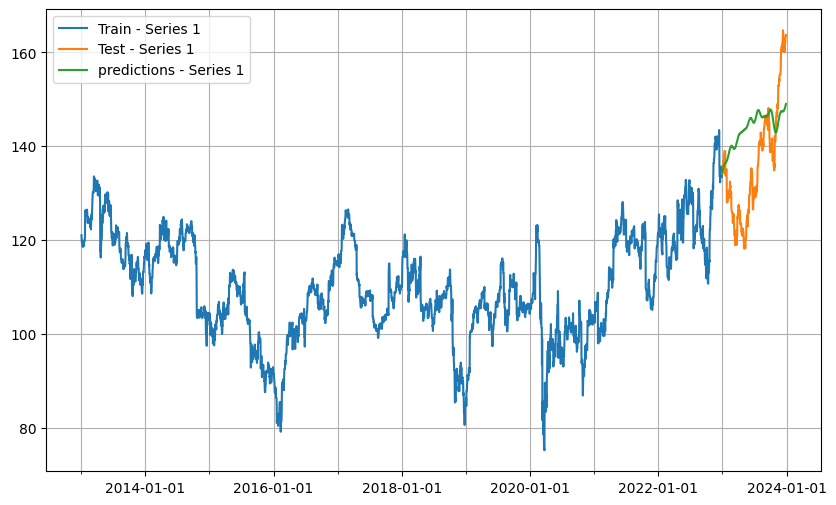

134.45887420371764


In [158]:
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon

# Create a new Prophet object
model = Prophet()

# Fit the model to the data
model.fit(train_transformed)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

plot_and_print_prediction(y_train, y_test, y_pred)

In [159]:
# error metrics:
model_name = 'Prophet_param0_t1'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0               SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1               SMA_gscv_win90_t1  47.875986  44.109975  0.321189
2  SES_gscv_damp0_trend0_sp365_t0  12.003485   9.616440  0.069203
3             SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
4    SES_gscv_trend0_s00_sp365_t1  11.626932   9.350516  0.067629
5               SMA_gscv_win90_t1  47.875986  44.109975  0.321189
6               Prophet_param0_t0  11.321214   9.437574  0.070089
7               Prophet_param0_t1  13.068697  11.127380  0.084908

In [160]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SMA_gscv_win90_t1  \
2022-12-30  134.223755         134.223755         134.223755   
2022-12-31  134.223755         134.223755         134.223755   
2023-01-01  134.223755         134.223755         134.223755   
2023-01-02  134.223755         134.223755         134.223755   
2023-01-03  134.852524         134.852524         134.852524   

            SES_gscv_alpha09_t0  SES_gscv_trend0_s00_sp365_t1  \
2022-12-30           134.223755                    134.223755   
2022-12-31           134.223755                    134.223755   
2023-01-01           134.223755                    134.223755   
2023-01-02           134.223755                    134.223755   
2023-01-03           134.852524                    134.852524   

            Prophet_param0_t0  Prophet_param0_t1  
2022-12-30         134.223755         134.223755  
2022-12-31         134.223755         134.223755  
2023-01-01         134.223755         134.223755  
2023-01-02         134.223755         134.223755  
2023-01-03         134.852524         134.852524

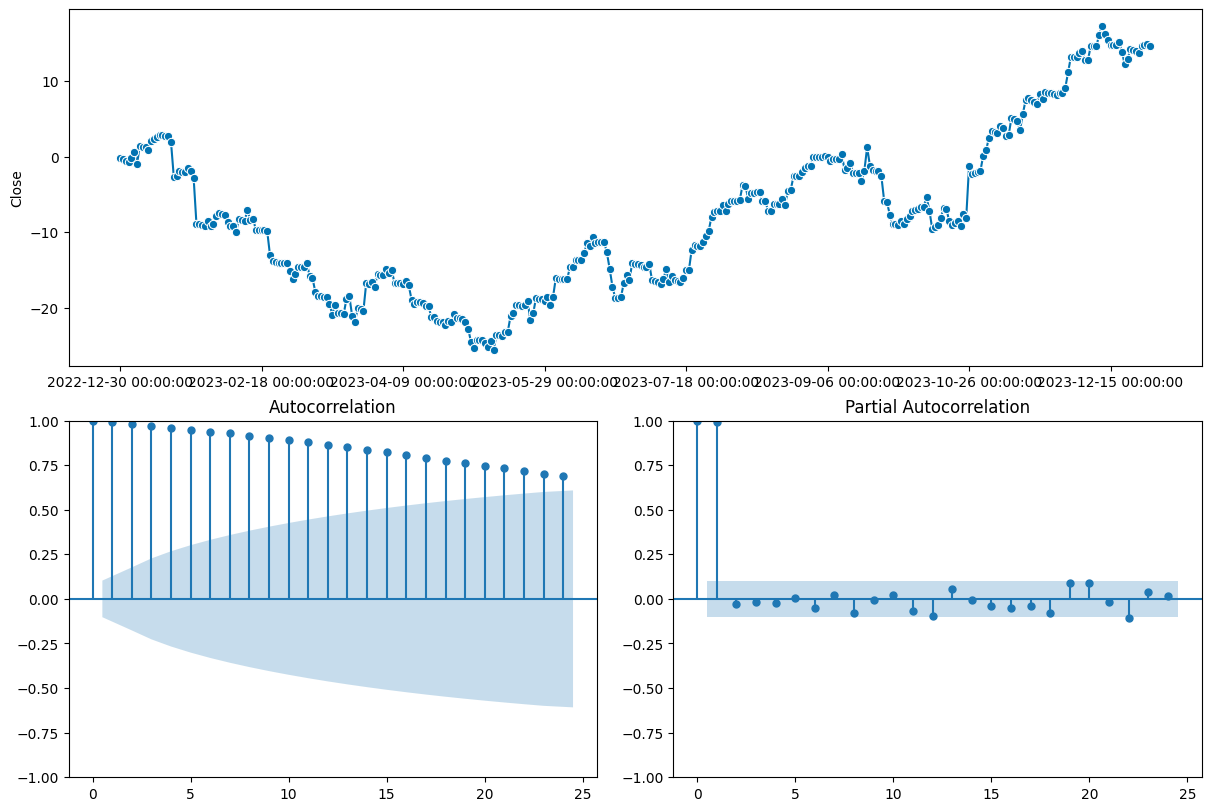

In [161]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()

#### t(1) Prophet * gridsearch WIP

### ARIMA

In [164]:
from sktime.forecasting.arima import ARIMA

#### --> t(0) ARIMA

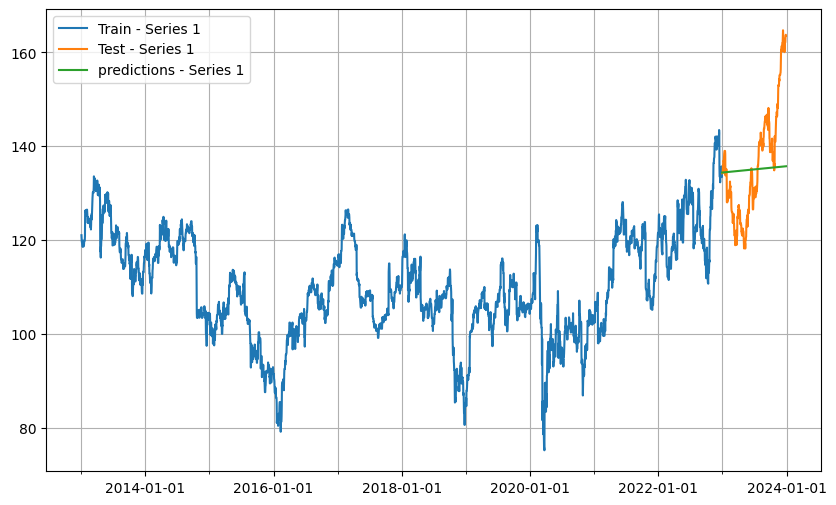

134.37825825147874


In [262]:
model = ARIMA(order=(1, 1, 0))
# parameters:
# p = 1 due to lag 1
# d = 1 due to input data not yet differenced
# q test 0 or 1

# Fit the model to the data
model.fit(y_train)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = model.predict(fh_n)

plot_and_print_prediction(y_train, y_test, y_pred)

In [177]:
# error metrics:
model_name = 'ARIMA_1_1_0_t(0)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0                SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1                SMA_gscv_win90_t1  47.875986  44.109975  0.321189
2   SES_gscv_damp0_trend0_sp365_t0  12.003485   9.616440  0.069203
3              SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
4     SES_gscv_trend0_s00_sp365_t1  11.626932   9.350516  0.067629
5                SMA_gscv_win90_t1  47.875986  44.109975  0.321189
6                Prophet_param0_t0  11.321214   9.437574  0.070089
7                Prophet_param0_t1  13.068697  11.127380  0.084908
8                 ARIMA_1_0_0_t(0)  22.540188  16.774908  0.115449
9                 ARIMA_1_1_0_t(0)  11.625930   9.349065  0.067615
10                ARIMA_1_1_1_t(0)  11.624995   9.348354  0.067610

In [263]:
#storing predictions
model_name = 'ARIMA_1_1_0_t(0)'
predictions_df[model_name] = y_pred.values
predictions_df.head()

y_test  SES_gscv_trend0_s00_sp365_t1  Prophet_param0_t0  \
2022-12-30  134.223755                    134.389374         129.266756   
2022-12-31  134.223755                    134.393037         129.373010   
2023-01-01  134.223755                    134.396699         129.477661   
2023-01-02  134.223755                    134.400361         129.636592   
2023-01-03  134.852524                    134.404024         129.723931   

            ARIMA_1_1_0_t(0)  
2022-12-30        134.378258  
2022-12-31        134.382067  
2023-01-01        134.385749  
2023-01-02        134.389432  
2023-01-03        134.393115

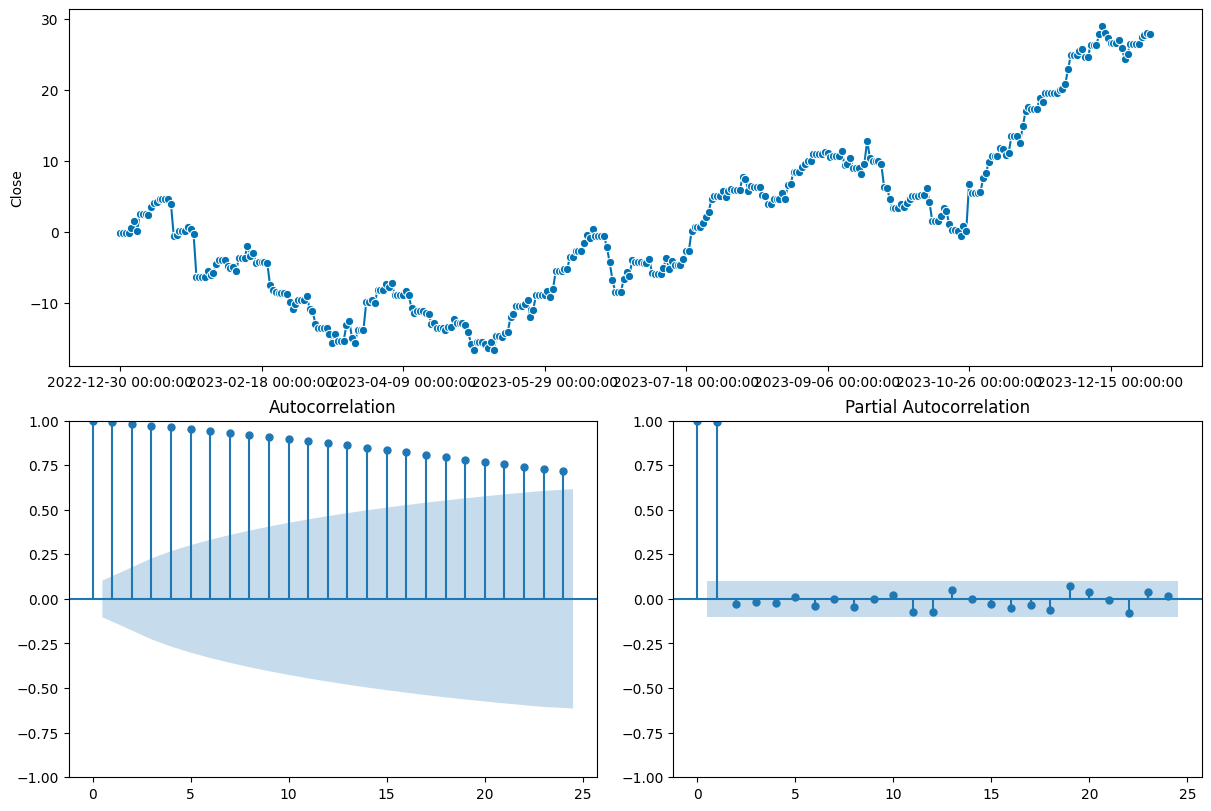

In [182]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()

In [184]:
from sktime.forecasting.model_evaluation import evaluate

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)
cv = ExpandingWindowSplitter(initial_window=3270, fh=90)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

df = evaluate(forecaster=model, y=y_train, cv=cv, strategy="refit", return_data=True)

#df.iloc[:, :5]
df.describe()

test_MeanAbsolutePercentageError    fit_time   pred_time  \
count                        290.000000  290.000000  290.000000   
mean                           0.074061    0.059824    0.005049   
min                            0.001146    0.054513    0.003767   
25%                            0.036862    0.057286    0.003919   
50%                            0.067354    0.058826    0.004016   
75%                            0.108906    0.060134    0.004289   
max                            0.175383    0.246239    0.183236   
std                            0.047704    0.011787    0.010929   

       len_train_window               cutoff  
count        290.000000                  290  
mean        3414.500000  2022-05-08 12:00:00  
min         3270.000000  2021-12-15 00:00:00  
25%         3342.250000  2022-02-25 06:00:00  
50%         3414.500000  2022-05-08 12:00:00  
75%         3486.750000  2022-07-19 18:00:00  
max         3559.000000  2022-09-30 00:00:00  
std           83.860002                  NaN

<Axes: xlabel='test_MeanAbsolutePercentageError', ylabel='Count'>

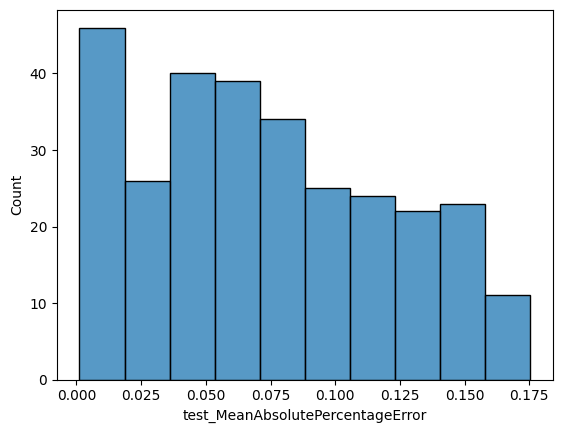

In [195]:
import seaborn as sns
plt.show()

sns.histplot(data=df, x='test_MeanAbsolutePercentageError')

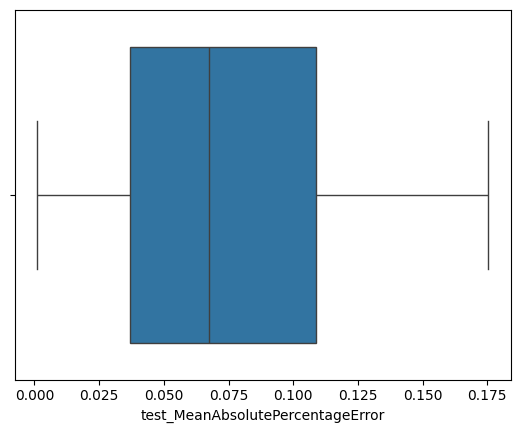

In [196]:
sns.boxplot(data=df, x='test_MeanAbsolutePercentageError')

plt.show()

#### t(1) ARIMA

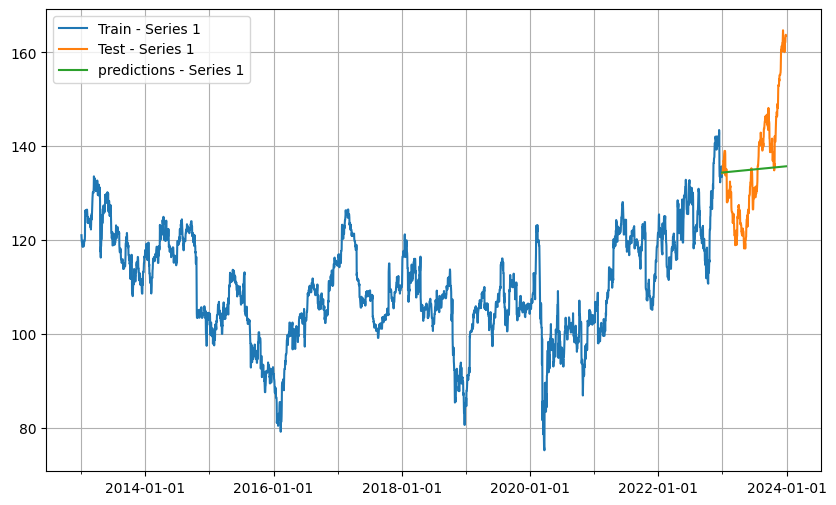

134.37823175983766


In [197]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon

# 1,0,0
# 1,1,0
# 1,1,1
# Create a new Prophet object
model = ARIMA(order=(1, 0, 0))

# Fit the model to the data
model.fit(train_transformed)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

plot_and_print_prediction(y_train, y_test, y_pred)


In [198]:
# saving error metrics:
model_name = 'ARIMA_1_0_0_t(1)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0                SMA_gscv_win90_t0  13.083018  10.022836  0.070315
1                SMA_gscv_win90_t1  47.875986  44.109975  0.321189
2   SES_gscv_damp0_trend0_sp365_t0  12.003485   9.616440  0.069203
3              SES_gscv_alpha09_t0  12.013235   9.618793  0.069187
4     SES_gscv_trend0_s00_sp365_t1  11.626932   9.350516  0.067629
5                SMA_gscv_win90_t1  47.875986  44.109975  0.321189
6                Prophet_param0_t0  11.321214   9.437574  0.070089
7                Prophet_param0_t1  13.068697  11.127380  0.084908
8                 ARIMA_1_0_0_t(0)  22.540188  16.774908  0.115449
9                 ARIMA_1_1_0_t(0)  11.625930   9.349065  0.067615
10                ARIMA_1_1_1_t(0)  11.624995   9.348354  0.067610
11                ARIMA_1_0_0_t(1)  11.628445   9.350918  0.067626

In [199]:
#storing predictions
predictions_df[model_name] = y_test.values
predictions_df.head()

y_test  SMA_gscv_win90_t0  SMA_gscv_win90_t1  \
2022-12-30  134.223755         134.223755         134.223755   
2022-12-31  134.223755         134.223755         134.223755   
2023-01-01  134.223755         134.223755         134.223755   
2023-01-02  134.223755         134.223755         134.223755   
2023-01-03  134.852524         134.852524         134.852524   

            SES_gscv_alpha09_t0  SES_gscv_trend0_s00_sp365_t1  \
2022-12-30           134.223755                    134.223755   
2022-12-31           134.223755                    134.223755   
2023-01-01           134.223755                    134.223755   
2023-01-02           134.223755                    134.223755   
2023-01-03           134.852524                    134.852524   

            Prophet_param0_t0  Prophet_param0_t1  ARIMA_1_0_0_t(0)  \
2022-12-30         134.223755         134.223755        134.223755   
2022-12-31         134.223755         134.223755        134.223755   
2023-01-01         134.223755         134.223755        134.223755   
2023-01-02         134.223755         134.223755        134.223755   
2023-01-03         134.852524         134.852524        134.852524   

            ARIMA_1_1_0_t(0)  ARIMA_1_1_1_t(0)  ARIMA_1_0_0_t(1)  
2022-12-30        134.223755        134.223755        134.223755  
2022-12-31        134.223755        134.223755        134.223755  
2023-01-01        134.223755        134.223755        134.223755  
2023-01-02        134.223755        134.223755        134.223755  
2023-01-03        134.852524        134.852524        134.852524

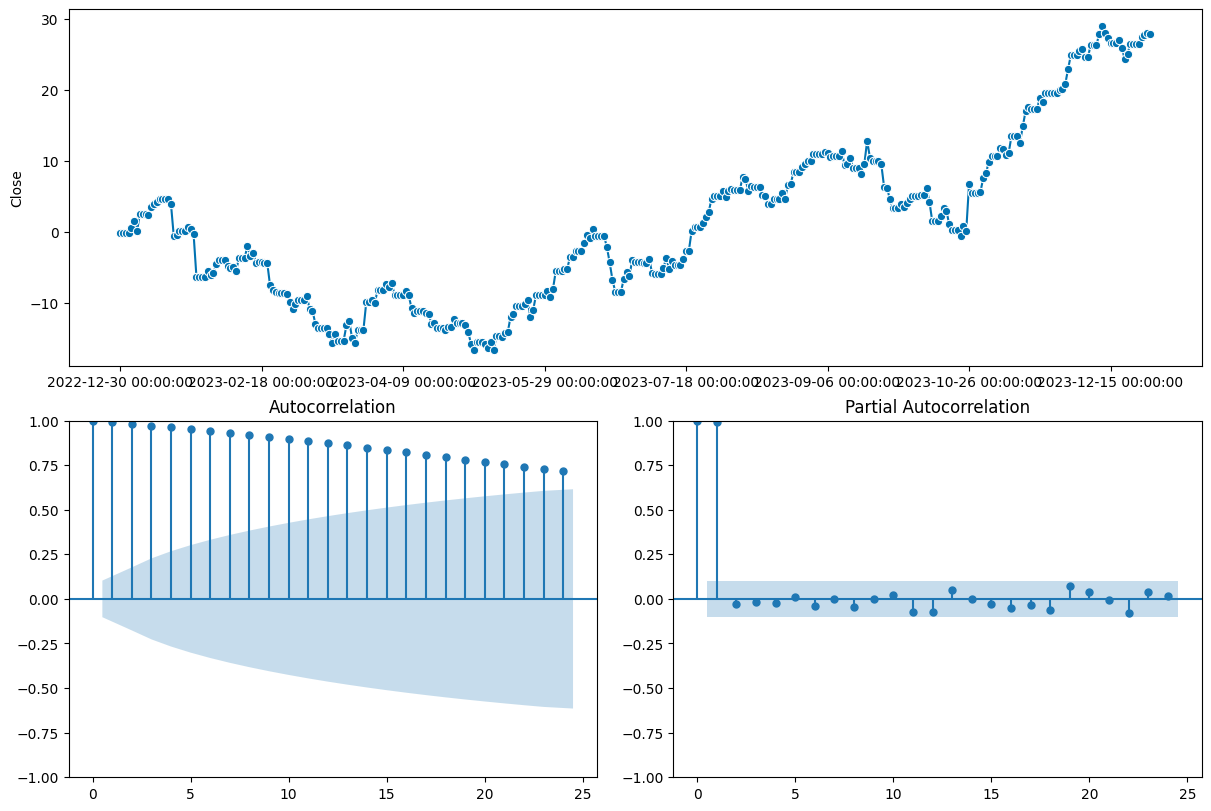

In [203]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()

#### Combi-Model

In [270]:
# store model predictions SES_gscv_trend0_s00_sp365_t1	Prophet_param0_t0	ARIMA_1_1_0_t(0)
#predictions_df.head()
model1_pred = predictions_df['Prophet_param0_t0'] #prophet (5)
model2_pred = predictions_df['SES_gscv_trend0_s00_sp365_t1']  #SES (4)
model3_pred = predictions_df['ARIMA_1_1_0_t(0)']  #SES (4) too similar to SES, not sued

# estimation of the weights for each model based on inverse proportional RMSE scores
RMSE_model1 = 11.321214 #prophet (5)
RMSE_model2 = 11.626932 # SES (4)

w10 = 1/RMSE_model1
w20 = 1/RMSE_model2
#w30 = 1/RMSE_model3
w1 = w10/(w10 + w20)
w2 = w20/(w10 + w20)
print(w1+w2)

1.0


In [271]:
# create model
#combined_model = (w1 * model1.predict()) + (w2 * model2.predict()) + (w3 * model3.predit())
combined_model = (w1 * model1_pred) + (w2 * model2_pred)
combined_model

2022-12-30    131.793943
2022-12-31    131.849585
2023-01-01    131.904414
2023-01-02    131.986745
2023-01-03    132.032803
                 ...    
2023-12-25    138.754484
2023-12-26    138.800038
2023-12-27    138.877922
2023-12-28    138.934923
2023-12-29    138.945648
Freq: D, Length: 365, dtype: float64

In [272]:
predictions_df['combined_model'] = combined_model.values
predictions_df.head()


y_test  SES_gscv_trend0_s00_sp365_t1  Prophet_param0_t0  \
2022-12-30  134.223755                    134.389374         129.266756   
2022-12-31  134.223755                    134.393037         129.373010   
2023-01-01  134.223755                    134.396699         129.477661   
2023-01-02  134.223755                    134.400361         129.636592   
2023-01-03  134.852524                    134.404024         129.723931   

            ARIMA_1_1_0_t(0)  combined_model  
2022-12-30        134.378258      131.793943  
2022-12-31        134.382067      131.849585  
2023-01-01        134.385749      131.904414  
2023-01-02        134.389432      131.986745  
2023-01-03        134.393115      132.032803

In [288]:
from sklearn.metrics import root_mean_squared_error
RMSE_combi_model = root_mean_squared_error(y_test, combined_model)
print(RMSE_combi_model)

11.243362975285068


In [289]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE_combi_model = mean_absolute_percentage_error(y_test, combined_model)
print(MAPE_combi_model)

0.06757569968345521


In [ ]:
model1_pred
model2_pred
combined_model

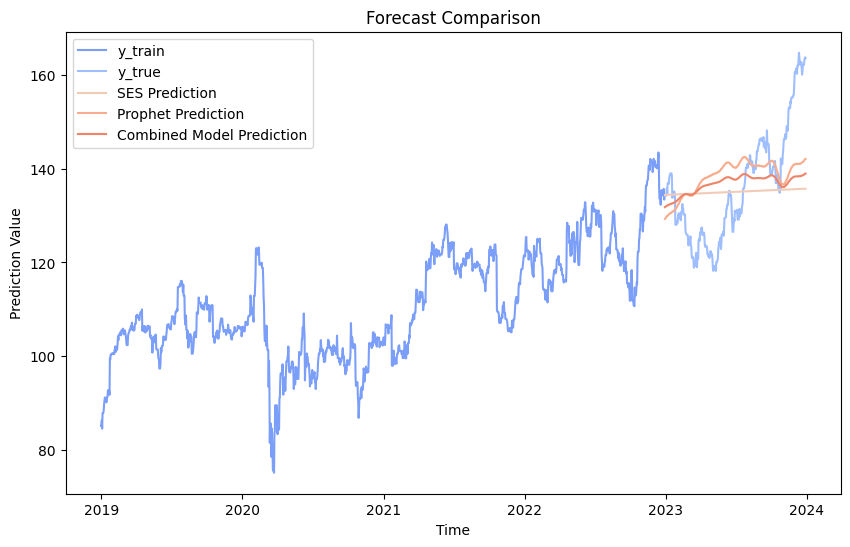

In [341]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the colormap
cmap = cm.get_cmap('coolwarm')

plt.figure(figsize=(10, 6))
# Plot each series
plt.plot(y_train.iloc[-365*4: ], label='y_train', color = cmap(0.2))
plt.plot(y_test, label='y_true', color = cmap(0.3))
plt.plot(model2_pred, label='SES Prediction', color = cmap(0.6))
plt.plot(model1_pred, label='Prophet Prediction', color = cmap(0.7))
plt.plot(combined_model, label='Combined Model Prediction', color = cmap(0.8))

# Set title and labels
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Prediction Value')

# Add legend
plt.legend()

# Display plot
plt.show()


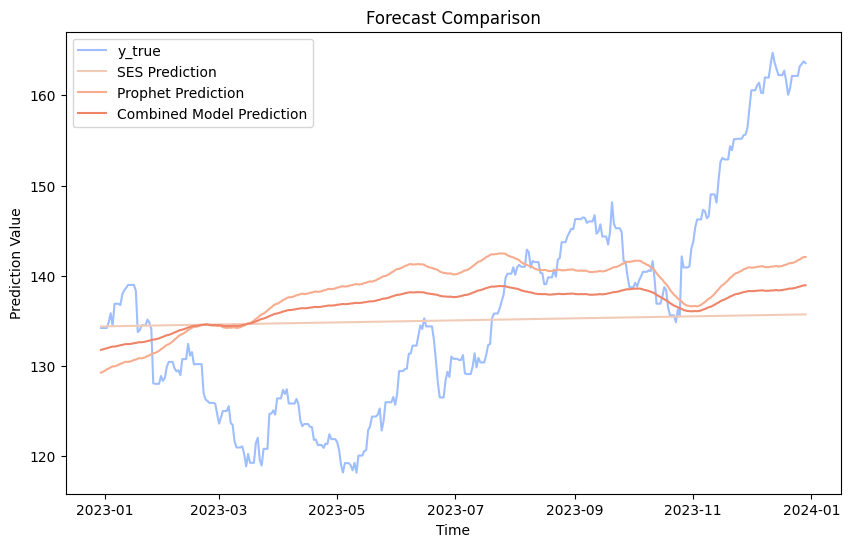

In [342]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the colormap
cmap = cm.get_cmap('coolwarm')

plt.figure(figsize=(10, 6))
# Plot each series
#plt.plot(y_train.iloc[-365*1: ], label='y_train', color = cmap(0.2))
plt.plot(y_test, label='y_true', color = cmap(0.3))
plt.plot(model2_pred, label='SES Prediction', color = cmap(0.6))
plt.plot(model1_pred, label='Prophet Prediction', color = cmap(0.7))
plt.plot(combined_model, label='Combined Model Prediction', color = cmap(0.8))

# Set title and labels
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Prediction Value')

# Add legend
plt.legend()

# Display plot
plt.show()


#### t(0) autoARIMA

In [286]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from matplotlib import pyplot

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

# create model
model_autoarima = AutoARIMA(start_p=1, max_p=10, sp=1, seasonal=False, suppress_warnings=True)

# fit model
model_autoarima.fit(y_train)
y_pred = model_autoarima.predict(fh_n)

# scores
model_name = 'autoARIMA_p1_10_sp1_t(0)'

error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result


Model      RMSE        MAE      MAPE
0  autoARIMA_p1_10_sp1_t(0)  15.31744  12.329825  0.078381

In [250]:
# saving error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0                    SMA_gscv_win3_t0  15.000758  12.049256  0.076594
1                   SMA_gscv_win30_t1  26.394814  21.503861  0.136863
2         SES_gscv_damp0_trend0_s5_t0  14.848146  11.916442  0.075752
3            SES_gscv_damp0_trend0_t0  15.320774  12.332927  0.078400
4      SES_gscv_damp0_trend0_sp365_t0  15.320774  12.332927  0.078400
5            SES_gscv_damp0_trend0_t1  13.510300  10.900504  0.069356
6   SES_gscv_damp0_trend0_sp365_s0_t1  13.510300  10.900504  0.069356
7                      SES_gscv_s0_t1  13.510300  10.900504  0.069356
8                   Prophet_param0_t0   8.811093   7.643583  0.050422
9                   Prophet_param0_t1  10.598033   8.732641  0.055728
10                   ARIMA_1_0_0_t(0)  19.866409  16.017380  0.101775
11                   ARIMA_1_1_0_t(0)  13.506661  10.897783  0.069339
12                   ARIMA_1_1_1_t(0)  13.500144  10.891824  0.069301
13                   ARIMA_1_0_0_t(1)  13.511943  10.901975  0.069366
14                   ARIMA_2_0_0_t(1)  13.496555  10.888162  0.069278
15           autoARIMA_p1_10_sp1_t(0)  15.317440  12.329825  0.078381

In [251]:
# summary of fit model
print(model_autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1005
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1733.150
Date:                Tue, 30 Jan 2024   AIC                           3470.300
Time:                        16:21:26   BIC                           3480.124
Sample:                    12-30-2020   HQIC                          3474.033
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0611      0.029      2.085      0.037       0.004       0.118
sigma2         1.8489      0.030     61.565      0.000       1.790       1.908
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [318]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError
from sktime.split import SlidingWindowSplitter

cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

# Create instances of the MeanAbsoluteErrr and MeanSquaredError classes
rmse = MeanSquaredError(square_root=True)
mae = MeanAbsoluteError()
mse = MeanSquaredError()
#mae
df = evaluate(forecaster=model_autoarima, y=y_train, cv=cv, scoring=[rmse], strategy="refit", return_data=True)

df.iloc[:, :]


test_MeanSquaredError  fit_time  pred_time  len_train_window     cutoff  \
0                 4.016229  0.173931   0.017617                30 2021-01-28   
1                 1.879585  0.074121   0.003458                30 2021-02-02   
2                 3.345535  0.067139   0.003281                30 2021-02-07   
3                 5.701508  0.076985   0.003284                30 2021-02-12   
4                 6.804465  0.139774   0.003601                30 2021-02-17   
..                     ...       ...        ...               ...        ...   
185               6.460114  0.066843   0.003636                30 2023-08-11   
186              14.405438  0.238468   0.003338                30 2023-08-16   
187               8.611446  0.180468   0.003874                30 2023-08-21   
188               3.648942  0.102677   0.003606                30 2023-08-26   
189               3.721929  0.151395   0.003593                30 2023-08-31   

                                               y_train  \
0    2020-12-30    102.727783
2020-12-31    104.000...   
1    2021-01-04    102.397301
2021-01-05    104.214...   
2    2021-01-09    106.189507
2021-01-10    106.189...   
3    2021-01-14    106.553001
2021-01-15    106.073...   
4    2021-01-19    106.594322
2021-01-20    107.470...   
..                                                 ...   
185  2023-07-13    130.911728
2023-07-14    130.403...   
186  2023-07-18    132.319382
2023-07-19    132.436...   
187  2023-07-23    135.818954
2023-07-24    136.405...   
188  2023-07-28    140.227646
2023-07-29    140.227...   
189  2023-08-02    140.931473
2023-08-03    141.205...   

                                                y_test  \
0    2021-02-27    99.571129
Freq: D, Name: Close, ...   
1    2021-03-04    100.559052
Freq: D, Name: Close,...   
2    2021-03-09    103.966553
Freq: D, Name: Close,...   
3    2021-03-14    106.838242
Freq: D, Name: Close,...   
4    2021-03-19    107.918243
Freq: D, Name: Close,...   
..                                                 ...   
185  2023-09-10    146.023911
Freq: D, Name: Close,...   
186  2023-09-15    144.352875
Freq: D, Name: Close,...   
187  2023-09-20    148.149811
Freq: D, Name: Close,...   
188  2023-09-25    144.837372
Freq: D, Name: Close,...   
189  2023-09-30    138.726685
Freq: D, Name: Close,...   

                                                y_pred  
0    2021-02-27    103.587358
Name: Close, dtype: f...  
1    2021-03-04    98.679466
Name: Close, dtype: fl...  
2    2021-03-09    100.621017
Name: Close, dtype: f...  
3    2021-03-14    101.136734
Name: Close, dtype: f...  
4    2021-03-19    101.113778
Name: Close, dtype: f...  
..                                                 ...  
185  2023-09-10    152.484025
Name: Close, dtype: f...  
186  2023-09-15    129.947437
Name: Close, dtype: f...  
187  2023-09-20    139.538364
Name: Close, dtype: f...  
188  2023-09-25    141.18843
Name: Close, dtype: fl...  
189  2023-09-30    142.448613
Name: Close, dtype: f...  

[190 rows x 8 columns]

In [319]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError
from sktime.split import SlidingWindowSplitter

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

cv = ExpandingWindowSplitter(
    step_length=5, fh=[30], initial_window=72)

# Create instances of the MeanAbsoluteErrr and MeanSquaredError classes
rmse = MeanSquaredError(square_root=True)
mae = MeanAbsoluteError()
mse = MeanSquaredError()
#mae
df = evaluate(forecaster=model_autoarima, y=y_train, cv=cv, scoring=[rmse], strategy="refit", return_data=True)

df.iloc[:, :]


test_MeanSquaredError  fit_time  pred_time  len_train_window     cutoff  \
0                 7.191757  0.071021   0.006077                72 2021-03-11   
1                 7.936128  0.123608   0.003843                77 2021-03-16   
2                12.226868  0.149779   0.004181                82 2021-03-21   
3                 5.065193  0.052249   0.003355                87 2021-03-26   
4                 7.216873  0.054850   0.003289                92 2021-03-31   
..                     ...       ...        ...               ...        ...   
176               3.258831  0.392314   0.003728               952 2023-08-08   
177               3.144384  0.244051   0.003475               957 2023-08-13   
178               4.480779  0.276555   0.003952               962 2023-08-18   
179               3.336432  0.240258   0.003499               967 2023-08-23   
180               2.860074  0.422484   0.003463               972 2023-08-28   

                                               y_train  \
0    2020-12-30    102.727783
2020-12-31    104.000...   
1    2020-12-30    102.727783
2020-12-31    104.000...   
2    2020-12-30    102.727783
2020-12-31    104.000...   
3    2020-12-30    102.727783
2020-12-31    104.000...   
4    2020-12-30    102.727783
2020-12-31    104.000...   
..                                                 ...   
176  2020-12-30    102.727783
2020-12-31    104.000...   
177  2020-12-30    102.727783
2020-12-31    104.000...   
178  2020-12-30    102.727783
2020-12-31    104.000...   
179  2020-12-30    102.727783
2020-12-31    104.000...   
180  2020-12-30    102.727783
2020-12-31    104.000...   

                                                y_test  \
0    2021-04-10    113.636497
Freq: D, Name: Close,...   
1    2021-04-15    110.999252
Freq: D, Name: Close,...   
2    2021-04-20    115.670952
Freq: D, Name: Close,...   
3    2021-04-25    119.245911
Freq: D, Name: Close,...   
4    2021-04-30    118.785431
Freq: D, Name: Close,...   
..                                                 ...   
176  2023-09-07    145.865723
Freq: D, Name: Close,...   
177  2023-09-12    144.659393
Freq: D, Name: Close,...   
178  2023-09-17    144.352875
Freq: D, Name: Close,...   
179  2023-09-22    145.262558
Freq: D, Name: Close,...   
180  2023-09-27    141.564499
Freq: D, Name: Close,...   

                                                y_pred  
0    2021-04-10    106.44474
Name: Close, dtype: fl...  
1    2021-04-15    103.063124
Name: Close, dtype: f...  
2    2021-04-20    103.444084
Name: Close, dtype: f...  
3    2021-04-25    114.180717
Name: Close, dtype: f...  
4    2021-04-30    111.568558
Name: Close, dtype: f...  
..                                                 ...  
176  2023-09-07    142.606892
Name: Close, dtype: f...  
177  2023-09-12    141.515009
Name: Close, dtype: f...  
178  2023-09-17    139.872096
Name: Close, dtype: f...  
179  2023-09-22    141.926126
Name: Close, dtype: f...  
180  2023-09-27    144.424573
Name: Close, dtype: f...  

[181 rows x 8 columns]

#### t(1) autoARIMA

In [277]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from matplotlib import pyplot

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

# create model
model_autoarima = AutoARIMA(start_p=1, max_p=10, sp=1, seasonal=False, suppress_warnings=True)

# fit model
model_autoarima.fit(train_transformed)
y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

# scores
model_name = 'autoARIMA_p1_10_sp1_t(1)'

error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

Model       RMSE        MAE      MAPE
0  autoARIMA_p1_10_sp1_t(1)  13.496555  10.888162  0.069278

In [254]:
# saving error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

Model       RMSE        MAE      MAPE
0                    SMA_gscv_win3_t0  15.000758  12.049256  0.076594
1                   SMA_gscv_win30_t1  26.394814  21.503861  0.136863
2         SES_gscv_damp0_trend0_s5_t0  14.848146  11.916442  0.075752
3            SES_gscv_damp0_trend0_t0  15.320774  12.332927  0.078400
4      SES_gscv_damp0_trend0_sp365_t0  15.320774  12.332927  0.078400
5            SES_gscv_damp0_trend0_t1  13.510300  10.900504  0.069356
6   SES_gscv_damp0_trend0_sp365_s0_t1  13.510300  10.900504  0.069356
7                      SES_gscv_s0_t1  13.510300  10.900504  0.069356
8                   Prophet_param0_t0   8.811093   7.643583  0.050422
9                   Prophet_param0_t1  10.598033   8.732641  0.055728
10                   ARIMA_1_0_0_t(0)  19.866409  16.017380  0.101775
11                   ARIMA_1_1_0_t(0)  13.506661  10.897783  0.069339
12                   ARIMA_1_1_1_t(0)  13.500144  10.891824  0.069301
13                   ARIMA_1_0_0_t(1)  13.511943  10.901975  0.069366
14                   ARIMA_2_0_0_t(1)  13.496555  10.888162  0.069278
15           autoARIMA_p1_10_sp1_t(0)  15.317440  12.329825  0.078381
16           autoARIMA_p1_10_sp1_t(1)  13.496555  10.888162  0.069278

In [278]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from sktime.split import SlidingWindowSplitter

cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

df = evaluate(forecaster=model_autoarima, y=y_train, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,0)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                            0.040335  0.154165   0.004020                30   
1                            0.018691  0.071183   0.003412                30   
2                            0.032179  0.067058   0.003280                30   
3                            0.053366  0.076451   0.003270                30   
4                            0.063052  0.140477   0.003610                30   
..                                ...       ...        ...               ...   
185                          0.044240  0.066682   0.003512                30   
186                          0.099793  0.239436   0.003268                30   
187                          0.058127  0.175542   0.003698                30   
188                          0.025193  0.102801   0.003508                30   
189                          0.026829  0.150745   0.003505                30   

        cutoff  
0   2021-01-28  
1   2021-02-02  
2   2021-02-07  
3   2021-02-12  
4   2021-02-17  
..         ...  
185 2023-08-11  
186 2023-08-16  
187 2023-08-21  
188 2023-08-26  
189 2023-08-31  

[190 rows x 5 columns]

## Models building part ii: Reduction: from forecasting to regression

### GradientBoost

#### t(0)

In [170]:
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
#RecursiveTabularRegressionForecaster(...)
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh_n)

# scores
model_name = 'reg_gradientboostin_param0_t(0)'

error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

Model       RMSE        MAE      MAPE
0  reg_gradientboostin_param0_t(0)  15.331065  12.350915  0.078522

#### t(1)

In [320]:
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

forecaster.fit(train_transformed)

#RecursiveTabularRegressionForecaster(...)
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = forecaster.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)
# scores
model_name = 'reg_gradientboostin_param0_t(1)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

Model       RMSE       MAE      MAPE
0  reg_gradientboostin_param0_t(1)  13.793493  11.23313  0.071559

### KNeighborsRegressor

#### t(0)

Model      RMSE        MAE      MAPE
0  reg_knn_n1_t(0)  13.82451  11.072884  0.070471

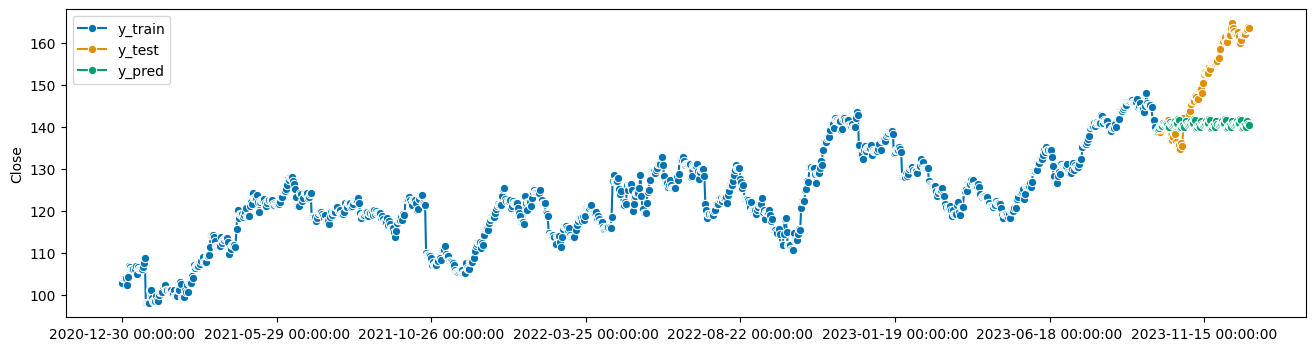

In [425]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series

regressor = KNeighborsRegressor(n_neighbors=2)
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh_n)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
#mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

# scores
model_name = 'reg_knn_n1_t(0)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

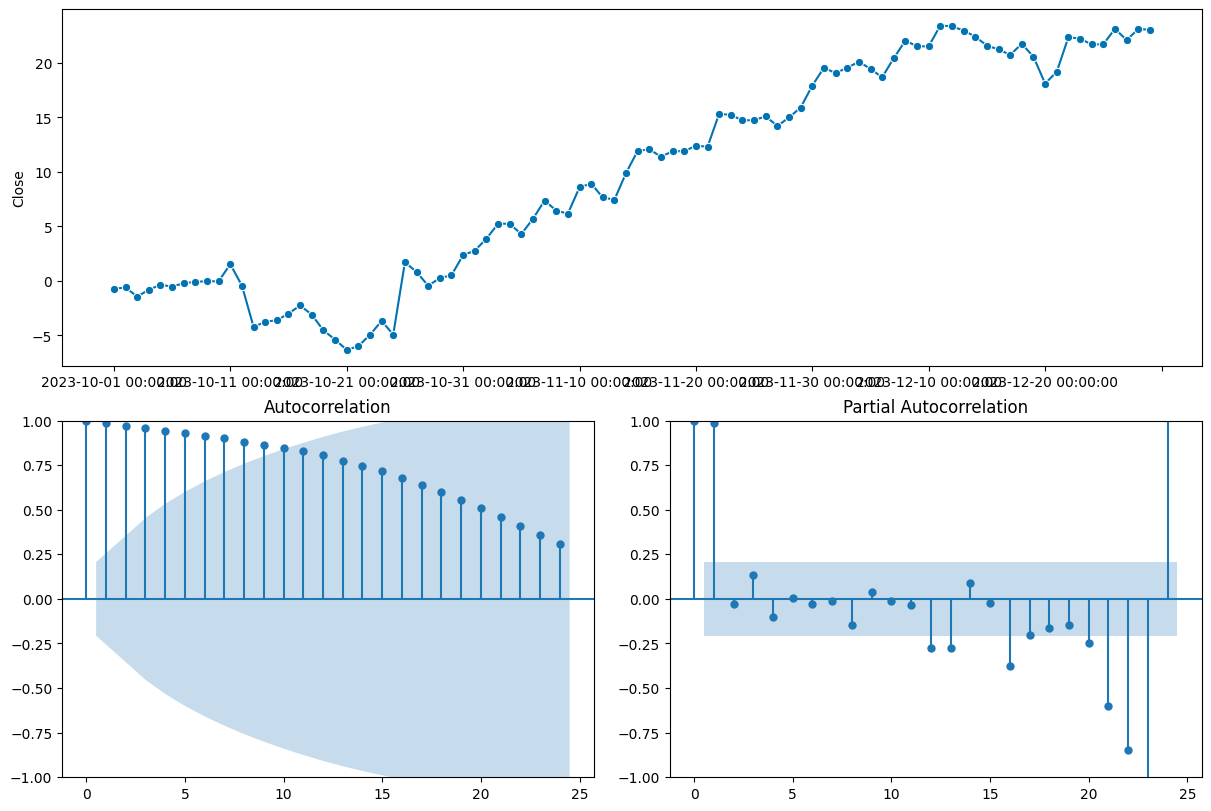

In [426]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


#### t(1)

Model       RMSE        MAE      MAPE
0  reg_gradientboostin_param0_t(1)  20.768039  15.494928  0.097782

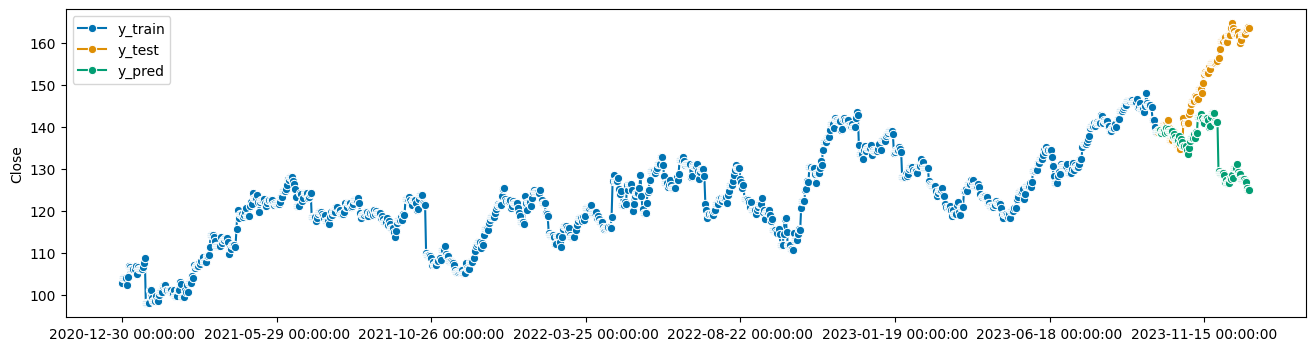

In [325]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=45, strategy="recursive")

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

forecaster.fit(train_transformed)

y_pred_transformed = forecaster.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# scores
model_name = 'reg_gradientboostin_param0_t(1)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

## Models: Bootstrap * ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

# Load your stock price data into a pandas DataFrame
# Assuming 'stock_data' has a 'closing_price' column
# Replace 'your_data.csv' with the actual file or data source

stock_data = pd.read_csv('your_data.csv')

# Define a function to fit ARIMA and return the prediction
def fit_arima(data):
    model = ARIMA(data, order=(1, 1, 0))  # Set appropriate p, d, q values
    fitted_model = model.fit()
    forecast = fitted_model.predict(start=len(data), end=len(data) + forecast_horizon - 1, typ='levels')
    return forecast
# Number of bootstrap samples
num_samples = 1000
# Number of days to forecast
forecast_horizon = 5
# Initialize an array to store bootstrap sample MSEs
bootstrap_mses = []

# Perform bootstrapping
for _ in range(num_samples):
    # Resample the data with replacement
    resampled_data = resample(stock_data['closing_price'].values)
    # Fit ARIMA on the resampled data
    forecast = fit_arima(resampled_data)
    # Evaluate the model's performance (e.g., using Mean Squared Error)
    true_values = stock_data['closing_price'].tail(forecast_horizon).values
    mse = mean_squared_error(true_values, forecast)
    # Store the MSE for this bootstrap sample
    bootstrap_mses.append(mse)
# Calculate the mean and confidence interval of the MSEs
mean_mse = np.mean(bootstrap_mses)
confidence_interval = np.percentile(bootstrap_mses, [2.5, 97.5])
print("Mean MSE:", mean_mse)
print("95% Confidence Interval:", confidence_interval)